# Install necessary libraries 

In [48]:
get_ipython().system('pip install torch torchvision transformers pillow pandas matplotlib tqdm nltk rouge-score rouge scikit-learn scikit-image opencv-python')

# Import necessary libraries


In [49]:
import os
import sys
import requests
import tarfile
import shutil
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import xml.etree.ElementTree as ET
from tqdm.notebook import tqdm
import re
from collections import Counter

# PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

## System Setup    

In [50]:
# NLP imports
from transformers import AutoTokenizer, GPT2Config, GPT2Model
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True

# Check device 
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

# Create directories for dataset
DATA_ROOT = "./IUXRAY_DATA_PIPELINE"
IMAGE_DIR = os.path.join(DATA_ROOT, "images")
REPORT_DIR = os.path.join(DATA_ROOT, "reports")
TEMP_DIR = os.path.join(DATA_ROOT, "temp")

# Create directories if they don't exist
for directory in [DATA_ROOT, IMAGE_DIR, REPORT_DIR, TEMP_DIR]:
    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f"Created directory: {directory}")
    else:
        print(f"Directory already exists: {directory}")

# Add output directories
RESULTS_ROOT = "./IUXRAY_OUTPUT_PIPELINE"
MODEL_DIR = os.path.join(RESULTS_ROOT, "models")
PLOT_DIR = os.path.join(RESULTS_ROOT, "plots")
LOG_DIR = os.path.join(RESULTS_ROOT, "logs")
CHECKPOINT_DIR = os.path.join(RESULTS_ROOT, 'checkpoints')

# Create all directories
for directory in [DATA_ROOT, IMAGE_DIR, REPORT_DIR, TEMP_DIR, 
                  RESULTS_ROOT, MODEL_DIR, PLOT_DIR, LOG_DIR,CHECKPOINT_DIR]:
    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f"Created directory: {directory}")
    else:
        print(f"Directory already exists: {directory}")

Using device: cuda
Directory already exists: ./IUXRAY_DATA_PIPELINE
Directory already exists: ./IUXRAY_DATA_PIPELINE/images
Directory already exists: ./IUXRAY_DATA_PIPELINE/reports
Directory already exists: ./IUXRAY_DATA_PIPELINE/temp
Directory already exists: ./IUXRAY_DATA_PIPELINE
Directory already exists: ./IUXRAY_DATA_PIPELINE/images
Directory already exists: ./IUXRAY_DATA_PIPELINE/reports
Directory already exists: ./IUXRAY_DATA_PIPELINE/temp
Directory already exists: ./IUXRAY_OUTPUT_PIPELINE
Directory already exists: ./IUXRAY_OUTPUT_PIPELINE/models
Directory already exists: ./IUXRAY_OUTPUT_PIPELINE/plots
Directory already exists: ./IUXRAY_OUTPUT_PIPELINE/logs
Directory already exists: ./IUXRAY_OUTPUT_PIPELINE/checkpoints


[nltk_data] Downloading package punkt to /home/ubuntu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ubuntu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/ubuntu/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Download Dataset

In [51]:
PNG_URL = "https://openi.nlm.nih.gov/imgs/collections/NLMCXR_png.tgz"
REPORTS_URL = "https://openi.nlm.nih.gov/imgs/collections/NLMCXR_reports.tgz"
VOCAB_URL = "https://openi.nlm.nih.gov/imgs/collections/radiology_vocabulary_final.xlsx"

def download_file(url, target_path, desc=None):
    try:
        response = requests.get(url, stream=True)
        
        if response.status_code != 200:
            print(f"Failed to download from {url}: {response.status_code}")
            return False
        
        total_size = int(response.headers.get('content-length', 0))
        block_size = 1024
        
        t = tqdm(total=total_size, unit='iB', unit_scale=True, desc=desc)
        
        with open(target_path, 'wb') as f:
            for data in response.iter_content(block_size):
                t.update(len(data))
                f.write(data)
        
        t.close()
        
        # Check if download was successful (file size match)
        if total_size != 0 and t.n != total_size:
            print(f"Download incomplete: {t.n} / {total_size} bytes")
            return False
            
        return True
    
    except Exception as e:
        print(f"Error downloading {url}: {e}")
        return False

def extract_tarfile(tar_path, extract_dir):
   
    try:
        with tarfile.open(tar_path) as tar:
            # Get total number of members
            members = tar.getmembers()
            total = len(members)
            
            # Extract with progress bar
            for i, member in enumerate(members):
                tar.extract(member, path=extract_dir)
                if i % 100 == 0:  # Update every 100 files
                    sys.stdout.write(f"\rExtracting: {i+1}/{total} files ({(i+1)/total*100:.1f}%)")
                    sys.stdout.flush()
            
            sys.stdout.write(f"\rExtraction completed: {total}/{total} files (100%)\n")
            return True
            
    except Exception as e:
        print(f"Error extracting {tar_path}: {e}")
        return False

def organize_files():
    # Find the extracted directories
    for root, dirs, files in os.walk(TEMP_DIR):
        # Look for PNG images
        for file in files:
            if file.endswith('.png'):
                src_path = os.path.join(root, file)
                dst_path = os.path.join(IMAGE_DIR, file)
                
                # Move file
                shutil.move(src_path, dst_path)
                
            # Look for XML reports
            elif file.endswith('.xml'):
                src_path = os.path.join(root, file)
                dst_path = os.path.join(REPORT_DIR, file)
                
                # Move file
                shutil.move(src_path, dst_path)
    
    # Count organized files
    image_count = len([f for f in os.listdir(IMAGE_DIR) if f.endswith('.png')])
    report_count = len([f for f in os.listdir(REPORT_DIR) if f.endswith('.xml')])
    
    print(f"Organized {image_count} images and {report_count} reports.")
    
    # Clean up temp directory
    shutil.rmtree(TEMP_DIR)
    print(f"Removed temporary directory: {TEMP_DIR}")

# %%
# Download the dataset
def download_dataset():
    print("Starting download of IU X-Ray dataset...")
    
    # 1. Download PNG images
    png_path = os.path.join(TEMP_DIR, "NLMCXR_png.tgz")
    if os.path.exists(png_path):
        print(f"PNG archive already exists at {png_path}. Skipping download.")
        png_downloaded = True
    else:
        png_downloaded = download_file(PNG_URL, png_path, "Downloading PNG images")
        if png_downloaded:
            print("PNG images downloaded successfully.")
        else:
            print("Failed to download PNG images.")
            return False
    
    # Extract PNG images if needed
    if png_downloaded:
        print("Extracting PNG images...")
        if extract_tarfile(png_path, TEMP_DIR):
            print("PNG images extracted successfully.")
        else:
            print("Failed to extract PNG images.")
            return False
    
    # 2. Download reports
    reports_path = os.path.join(TEMP_DIR, "NLMCXR_reports.tgz")
    if os.path.exists(reports_path):
        print(f"Reports archive already exists at {reports_path}. Skipping download.")
        reports_downloaded = True
    else:
        reports_downloaded = download_file(REPORTS_URL, reports_path, "Downloading reports")
        if reports_downloaded:
            print("Reports downloaded successfully.")
        else:
            print("Failed to download reports.")
            return False
    
    # Extract reports if needed
    if reports_downloaded:
        print("Extracting reports...")
        if extract_tarfile(reports_path, TEMP_DIR):
            print("Reports extracted successfully.")
        else:
            print("Failed to extract reports.")
            return False
    
    # 3. Download vocabulary
    vocab_path = os.path.join(DATA_ROOT, "radiology_vocabulary_final.xlsx")
    if os.path.exists(vocab_path):
        print(f"Vocabulary file already exists at {vocab_path}. Skipping download.")
    else:
        if download_file(VOCAB_URL, vocab_path, "Downloading vocabulary"):
            print("Vocabulary downloaded successfully.")
        else:
            print("Failed to download vocabulary, but continuing with images and reports.")
    
    # 4. Organize files
    print("Organizing files...")
    organize_files()
    
    print("Dataset download and organization completed.")
    return True

# Check if the dataset already exists
def check_dataset_exists():
    """Check if the dataset has already been downloaded and extracted."""
    image_files = [f for f in os.listdir(IMAGE_DIR) if f.endswith('.png')]
    report_files = [f for f in os.listdir(REPORT_DIR) if f.endswith('.xml')]
    
    if len(image_files) > 0 and len(report_files) > 0:
        print(f"Dataset already exists with {len(image_files)} images and {len(report_files)} reports.")
        return True
    return False

if not check_dataset_exists():
    print("Dataset not found. Starting download...")
    download_dataset()
else:
    print("Using existing dataset. Skipping download step.")

Dataset already exists with 7470 images and 3955 reports.
Using existing dataset. Skipping download step.


## Data Exploration and Preprocessing


Found 7470 images and 3955 reports


Processing reports:   0%|          | 0/3955 [00:00<?, ?it/s]

Created DataFrame with 7470 image-report pairs

=== Dataset Statistics ===

Missing values in dataset:
image_id                  0
image_path                0
report_path               0
mesh_terms                0
findings                  0
impression                0
full_report               0
findings_word_count       0
impression_word_count     0
full_report_word_count    0
dtype: int64

Empty text fields:
Empty findings: 997 (13.3%)
Empty impression: 52 (0.7%)
Empty full_report: 40 (0.5%)

Report completeness:
Reports with both findings and impression: 6461 (86.5%)
Reports with only findings: 12 (0.2%)
Reports with only impression: 957 (12.8%)
Reports with neither section: 40 (0.5%)

Findings word count:
count    7470.000000
mean       27.141232
std        17.089097
min         0.000000
25%        18.000000
50%        27.000000
75%        36.000000
max       169.000000
Name: findings_word_count, dtype: float64

Impression word count:
count    7470.000000
mean       10.467871
std

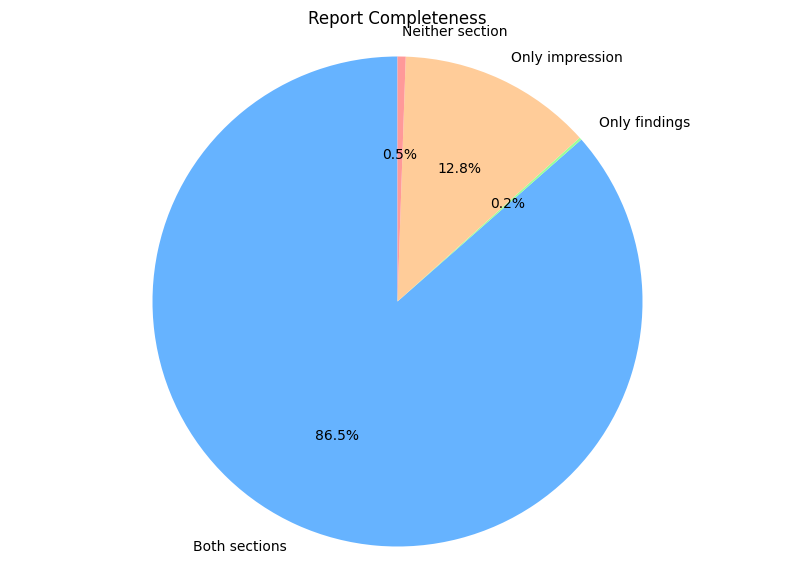

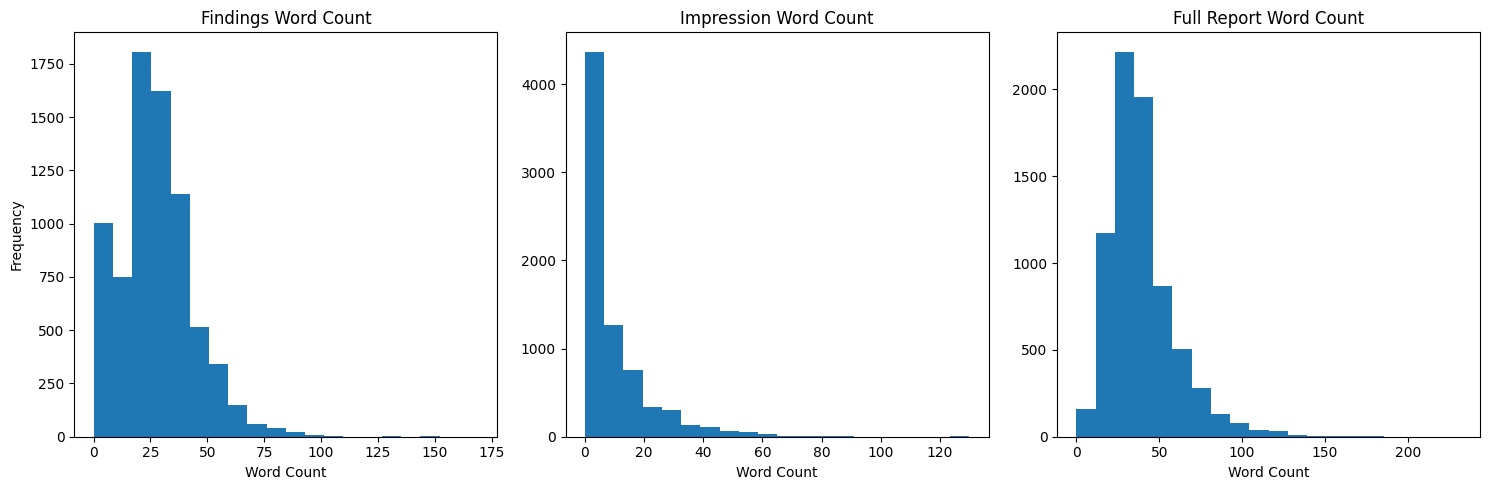

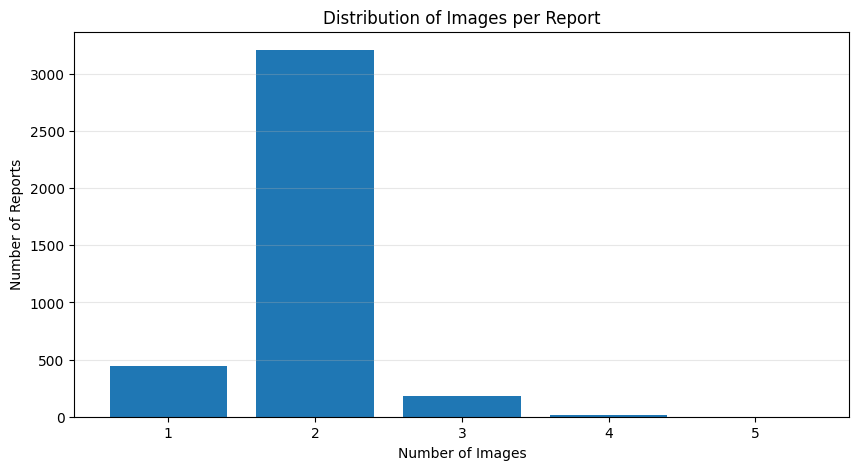

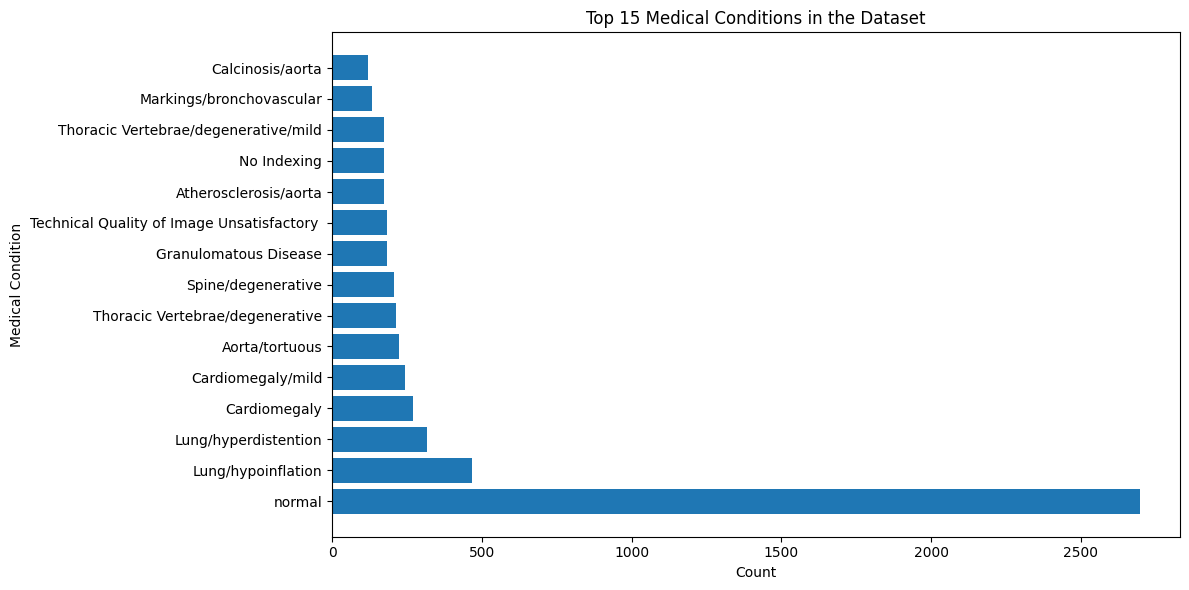

Processing medical vocabulary:   0%|          | 0/7470 [00:00<?, ?it/s]


Top 20 Words in Findings:
normal: 6692
pleural: 4733
pneumothorax: 4606
redacted: 4491
effusion: 4301
heart: 4059
lungs: 3754
size: 3666
focal: 3349
within: 2929
clear: 2878
limits: 2821
pulmonary: 2285
consolidation: 2054
silhouette: 1885
right: 1702
mediastinal: 1624
airspace: 1574
cardiomediastinal: 1570
left: 1456

Top 20 Words in Impressions:
acute: 4494
cardiopulmonary: 3151
disease: 2038
redacted: 2005
abnormality: 1598
right: 1063
normal: 1021
pulmonary: 950
left: 892
findings: 891
chest: 789
lungs: 774
clear: 730
active: 676
pleural: 670
heart: 670
lung: 656
process: 648
size: 638
evidence: 603


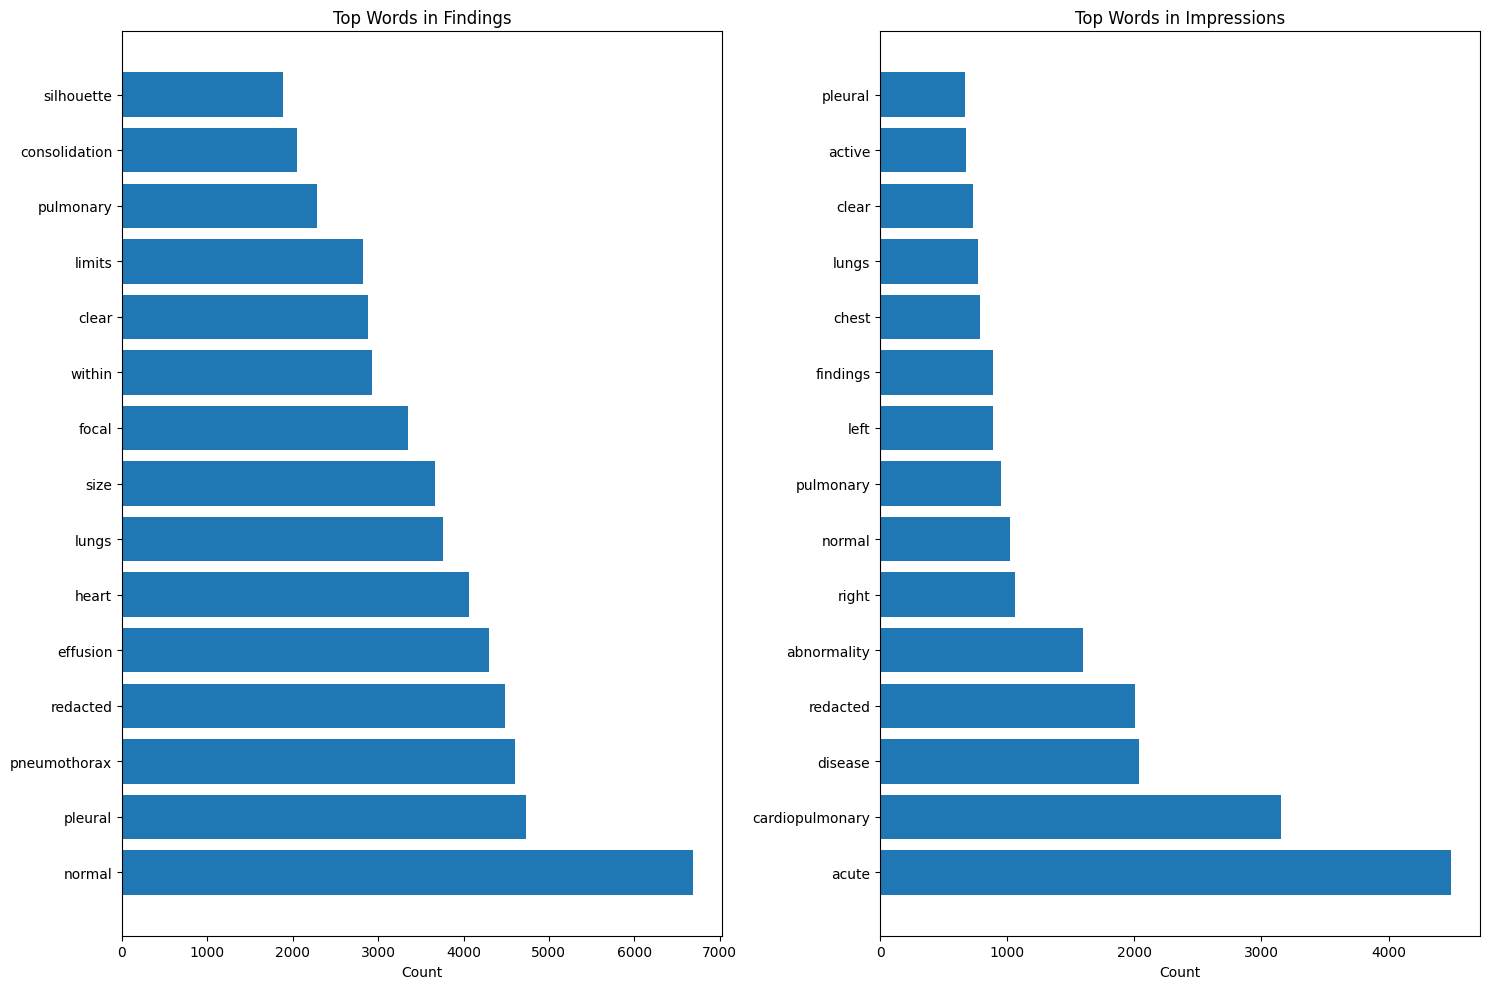


Displaying random samples from the dataset:


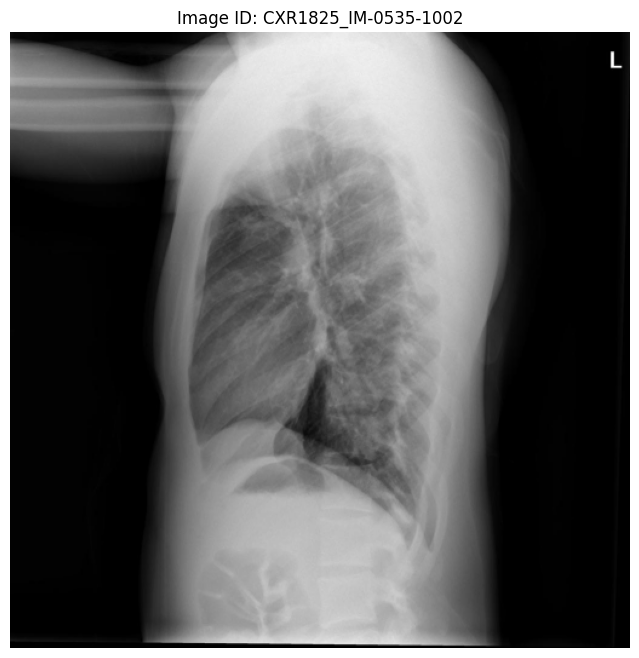

Image ID: CXR1825_IM-0535-1002

MeSH Terms: Scoliosis/mild

Findings: None

Impression: Heart size is normal lungs are clear. No evidence of tuberculosis. Minimal scoliosis.




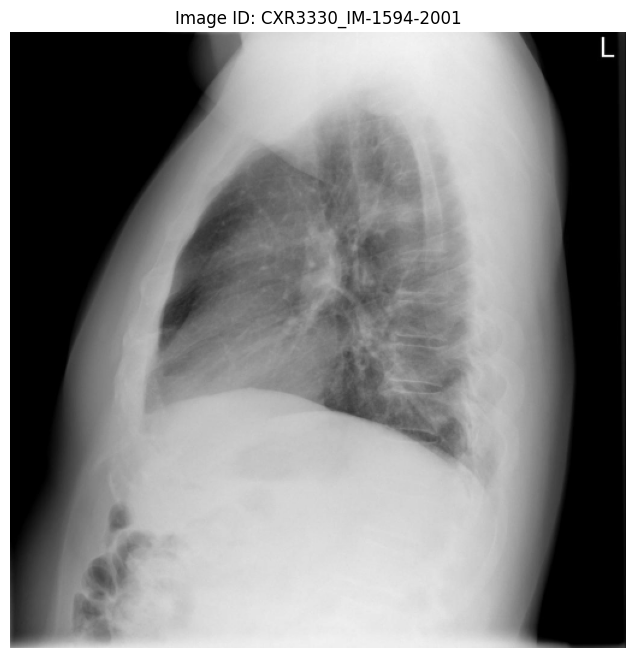

Image ID: CXR3330_IM-1594-2001

MeSH Terms: normal

Findings: The heart is normal in size. The mediastinum is unremarkable. The lungs are clear.

Impression: No acute disease.




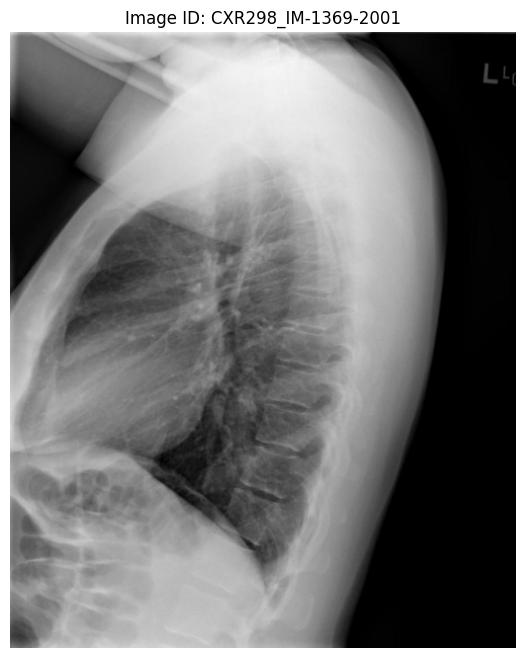

Image ID: CXR298_IM-1369-2001

MeSH Terms: normal

Findings: The lungs are clear. There is no pleural effusion or pneumothorax. The heart and mediastinum are normal. The skeletal structures are normal.

Impression: No acute pulmonary disease.




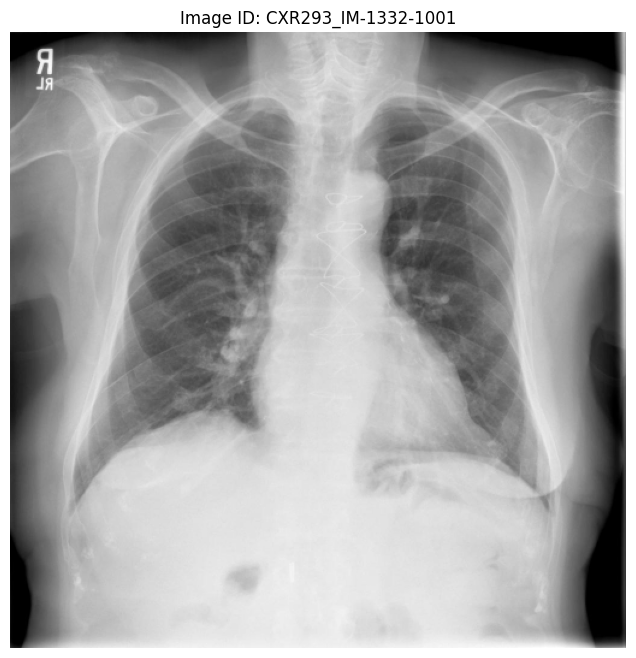

Image ID: CXR293_IM-1332-1001

MeSH Terms: Surgical Instruments/mediastinum, Deformity/thoracic vertebrae

Findings: Sternotomy [REDACTED] mediastinal clips noted. Heart size within normal limits. Negative for focal pulmonary consolidation, pleural effusion, or pneumothorax. There is [REDACTED] deformity of T6, [REDACTED] since X-[REDACTED] thoracic spine [REDACTED], [REDACTED]. Mild [REDACTED] deformity of T12, stable. Prior cholecystectomy.

Impression: 1. No definite evidence of metastatic disease. 2. Age-indeterminate [REDACTED] deformity of T6, [REDACTED] since study dated [REDACTED], [REDACTED]. .




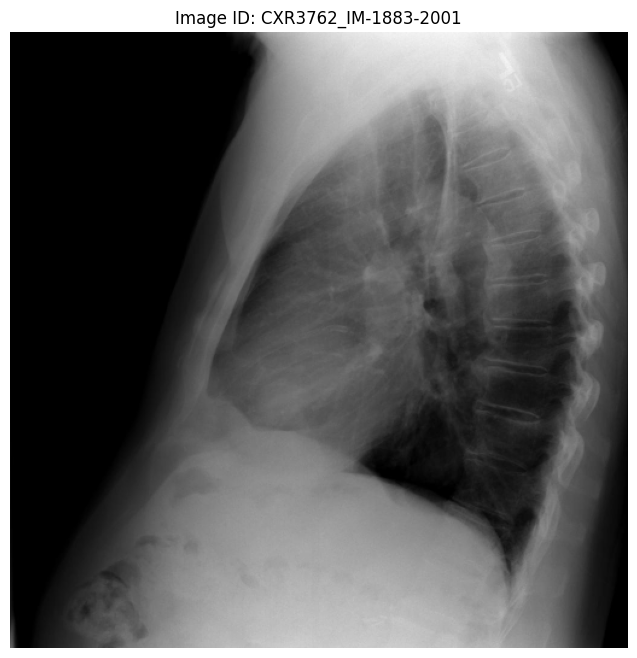

Image ID: CXR3762_IM-1883-2001

MeSH Terms: Calcinosis/coronary vessels/left

Findings: Heart size, mediastinal contour, and pulmonary vascularity are within normal limits. No focal consolidation, suspicious pulmonary opacity, large pleural effusion, or pneumothorax is identified. Calcified left coronary arteries noted. Visualized osseous structures appear intact.

Impression: No acute cardiopulmonary abnormality. Calcified left coronary arteries noted. .




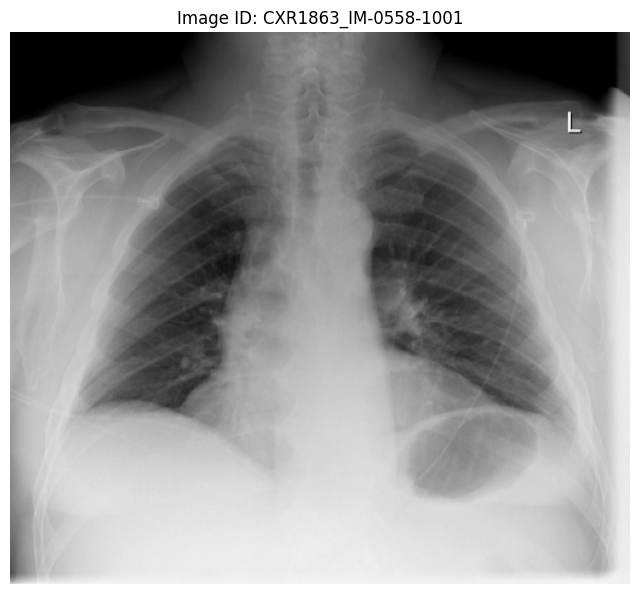

Image ID: CXR1863_IM-0558-1001

MeSH Terms: Cardiomegaly/mild, Aorta/tortuous, Lung/hypoinflation, Markings/bronchovascular, Pulmonary Atelectasis/base/patchy, Spine/degenerative

Findings: Heart size is mildly enlarged. Tortuous aorta. Lung volumes are low with central bronchovascular crowding and patchy basilar atelectasis.. Degenerative changes of the spine.

Impression: 1. Low volume study without acute process. 2. Mild cardiomegaly.




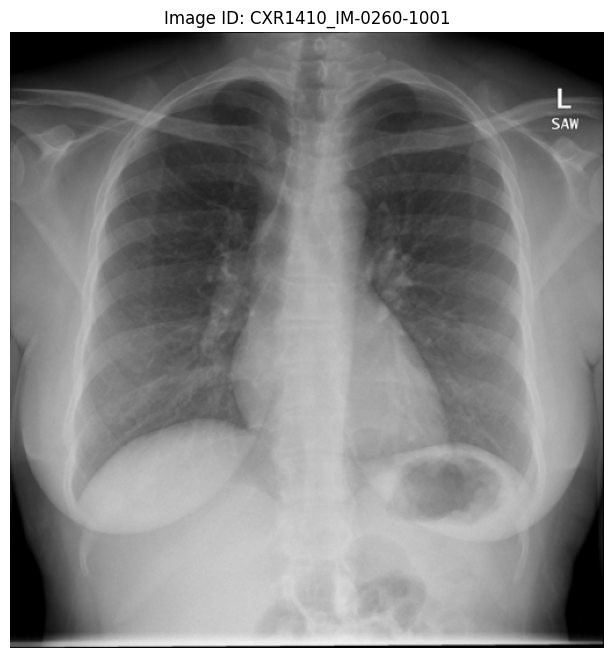

Image ID: CXR1410_IM-0260-1001

MeSH Terms: normal

Findings: The heart size is normal. The mediastinal contour is within normal limits. The lungs are free of any focal infiltrates. There are no nodules or masses. No visible pneumothorax. No visible pleural fluid. The [REDACTED] are grossly normal. There is no visible free intraperitoneal air under the diaphragm.

Impression: 1. No acute radiographic cardiopulmonary process.




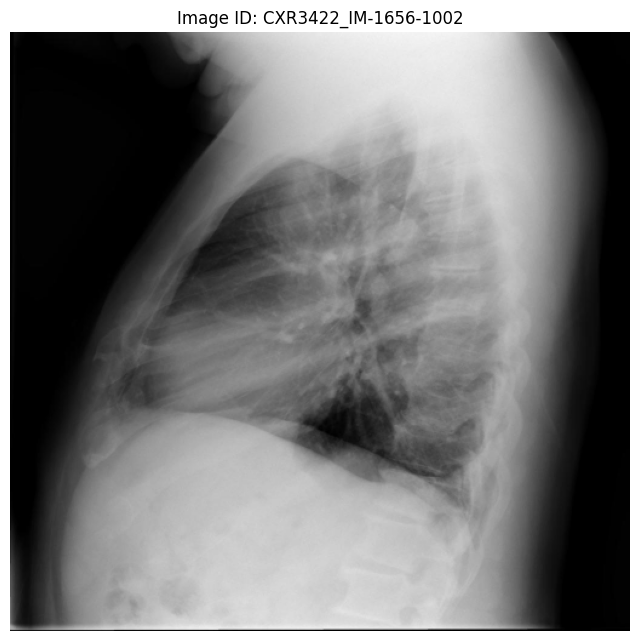

Image ID: CXR3422_IM-1656-1002

MeSH Terms: normal

Findings: Heart size normal. Lungs are clear. [REDACTED] are normal. No pneumonia, effusions, edema, pneumothorax, adenopathy, nodules or masses.

Impression: Normal chest




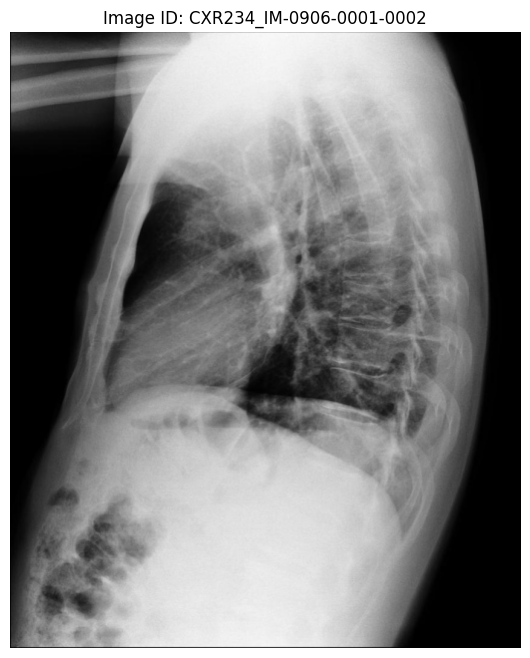

Image ID: CXR234_IM-0906-0001-0002

MeSH Terms: normal

Findings: The trachea is midline. The cardiomediastinal silhouette is normal. The lungs are clear, without focal consolidation or effusion. There is no pneumothorax. The visualized bony structures reveal no acute abnormalities. Lateral view reveals mild degenerative changes of the thoracic spine. No layering pleural effusion or pneumothorax seen on decubitus exam.

Impression: Chest x-[REDACTED], lateral, and decubitus. 1. No acute cardiopulmonary abnormalities. 2. No evidence of pleural effusion. .




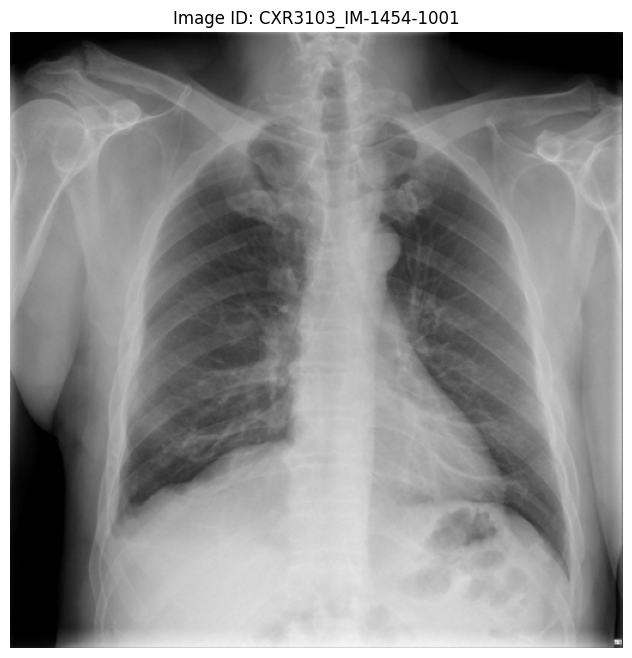

Image ID: CXR3103_IM-1454-1001

MeSH Terms: Diaphragmatic Eventration/right, Pulmonary Atelectasis/base/left/mild

Findings: Cardiomediastinal silhouette stable and unremarkable. Stable eventration of the right hemidiaphragm. There is redemonstration without significant interval change of mild subsegmental atelectasis of the left base. Pneumonia seen on CT examination dated [REDACTED], [REDACTED] (not seen on prior chest x-[REDACTED]) is not seen either on [REDACTED] chest x-[REDACTED].

Impression: No acute cardiopulmonary abnormality..




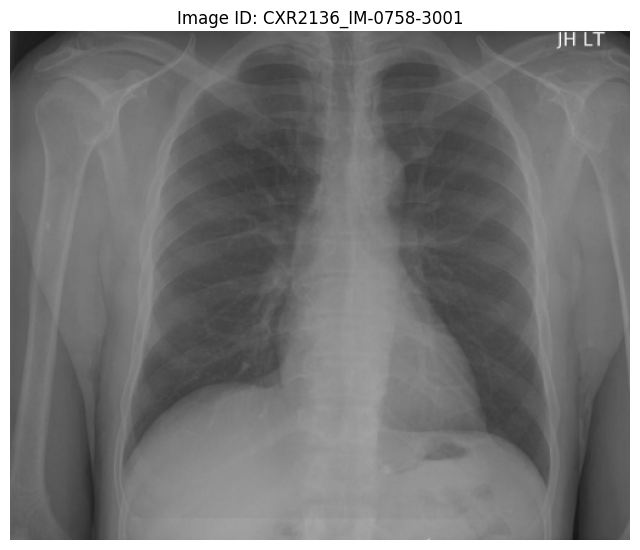

Image ID: CXR2136_IM-0758-3001

MeSH Terms: normal

Findings: Mediastinal contours are normal. Lungs are clear. There is no pneumothorax or large pleural effusion.

Impression: No acute cardiopulmonary abnormality.




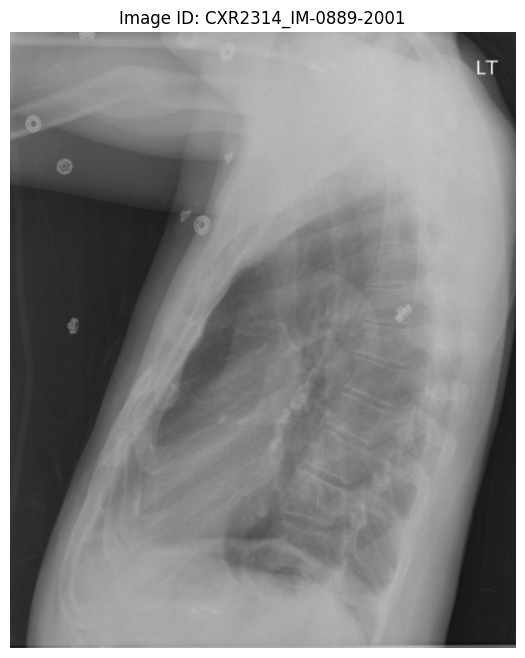

Image ID: CXR2314_IM-0889-2001

MeSH Terms: Opacity/costophrenic angle/right/multiple, Pulmonary Disease, Chronic Obstructive, Pulmonary Atelectasis/costophrenic angle/right/focal

Findings: The lungs are [REDACTED]. [REDACTED] opacities are present in the right costophrenic [REDACTED]. No focal infiltrates. Heart size normal.

Impression: Findings of COPD with right costophrenic [REDACTED] focal atelectasis.




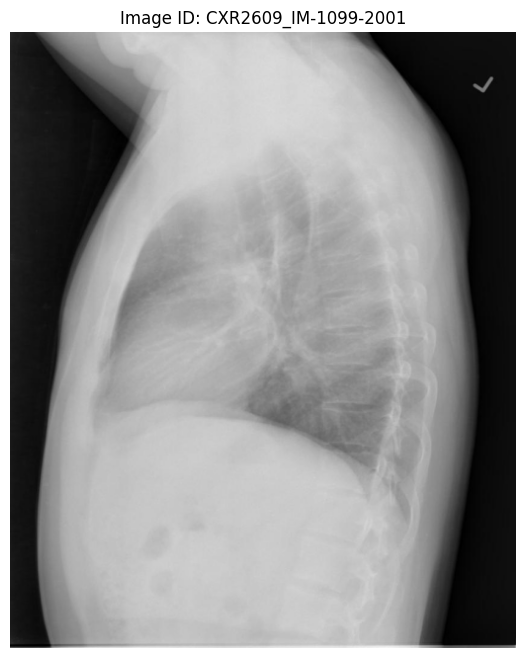

Image ID: CXR2609_IM-1099-2001

MeSH Terms: normal

Findings: None

Impression: No active disease.




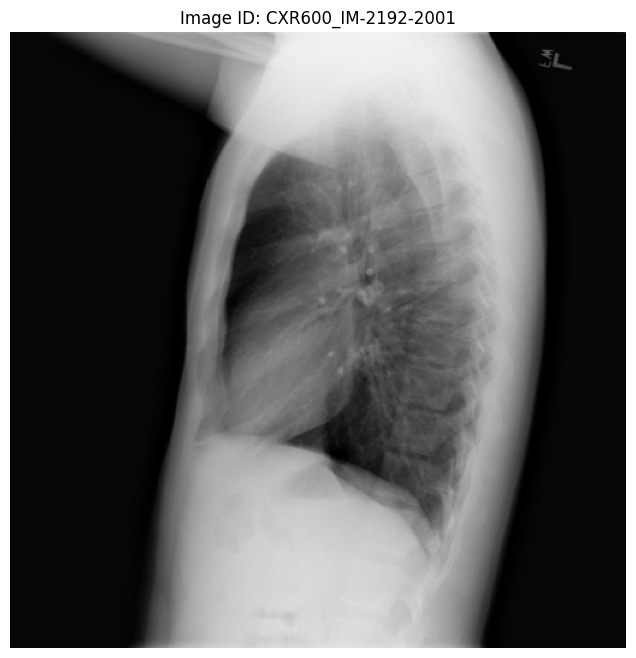

Image ID: CXR600_IM-2192-2001

MeSH Terms: Calcinosis/lung/hilum/lymph nodes/left, Calcified Granuloma/lung/hilum/left, Fractures, Bone/clavicle/right/healed

Findings: The cardiomediastinal silhouette is normal in size and contour. Calcified left hilar lymph [REDACTED]/granulomas. No focal consolidation, pneumothorax or large pleural effusion. Old fracture, right mid clavicle.

Impression: Negative for acute abnormality.




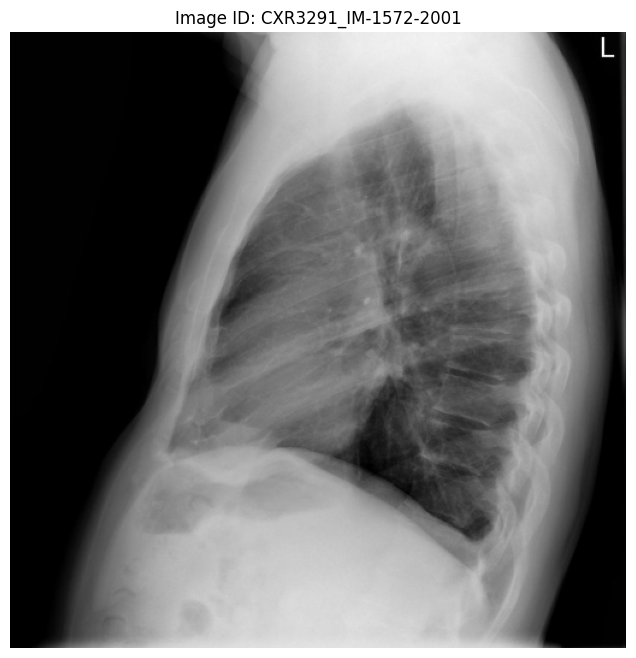

Image ID: CXR3291_IM-1572-2001

MeSH Terms: normal

Findings: The lungs are clear. The heart and pulmonary [REDACTED] are normal. The pleural spaces are clear. Mediastinal contours are normal.

Impression: No acute cardiopulmonary disease




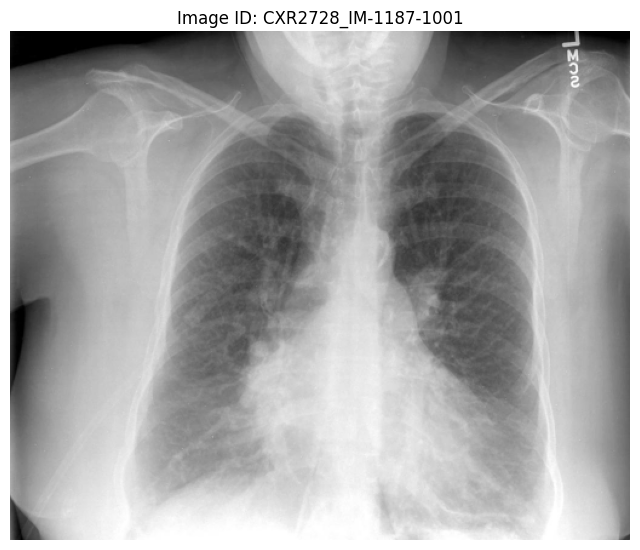

Image ID: CXR2728_IM-1187-1001

MeSH Terms: Lung/hyperdistention, Opacity/lung/middle lobe/right, Pulmonary Congestion, Pulmonary Disease, Chronic Obstructive, Cicatrix/lung/middle lobe/right/chronic, Pulmonary Atelectasis/middle lobe/right/chronic, Hypertension, Pulmonary

Findings: Lungs remain hyperexpanded. No change in the right middle lobe opacification. No [REDACTED] infiltrates or masses. Pulmonary arteries are prominent centrally.

Impression: [REDACTED] change COPD. Chronic right middle lobe scar and atelectasis. Pulmonary arterial hypertension.




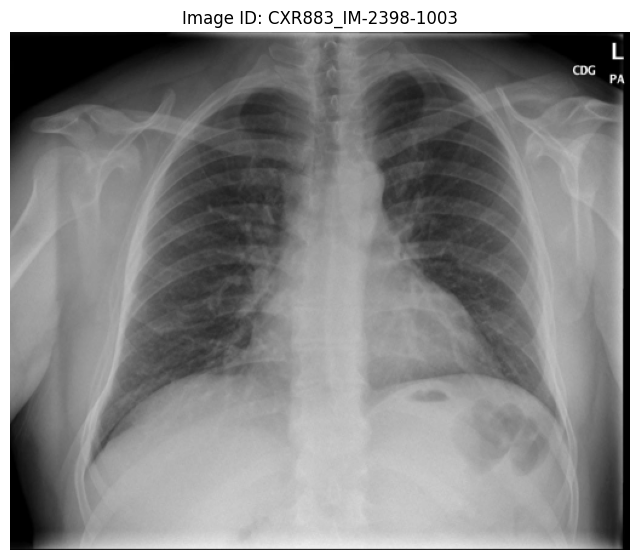

Image ID: CXR883_IM-2398-1003

MeSH Terms: normal

Findings: None

Impression: Heart size is normal. Lungs are clear. No evidence of tuberculosis




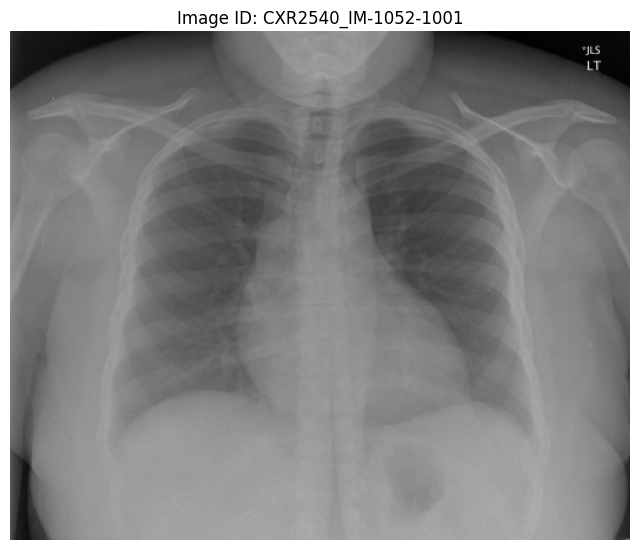

Image ID: CXR2540_IM-1052-1001

MeSH Terms: normal

Findings: The lungs are clear bilaterally. Specifically, no evidence of focal consolidation, pneumothorax, or pleural effusion. Cardiomediastinal silhouette is unremarkable. Visualized osseous structures of the thorax are without acute abnormality.

Impression: No acute cardiopulmonary abnormality.




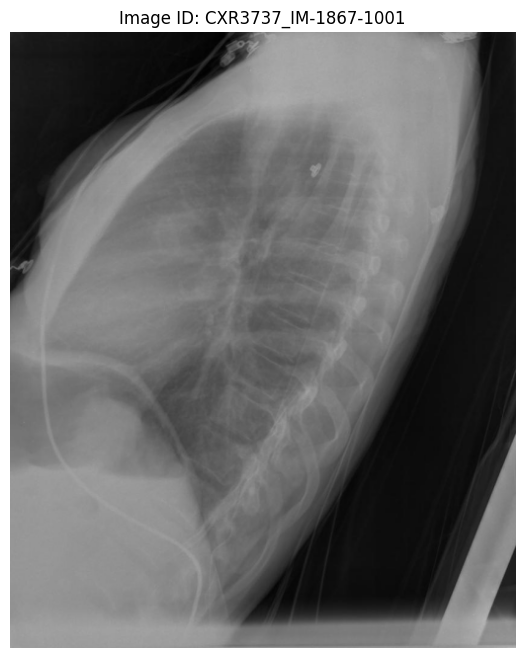

Image ID: CXR3737_IM-1867-1001

MeSH Terms: normal

Findings: Heart size within normal limits. No focal airspace disease. No pneumothorax or pleural effusion.

Impression: No acute cardiopulmonary findings.




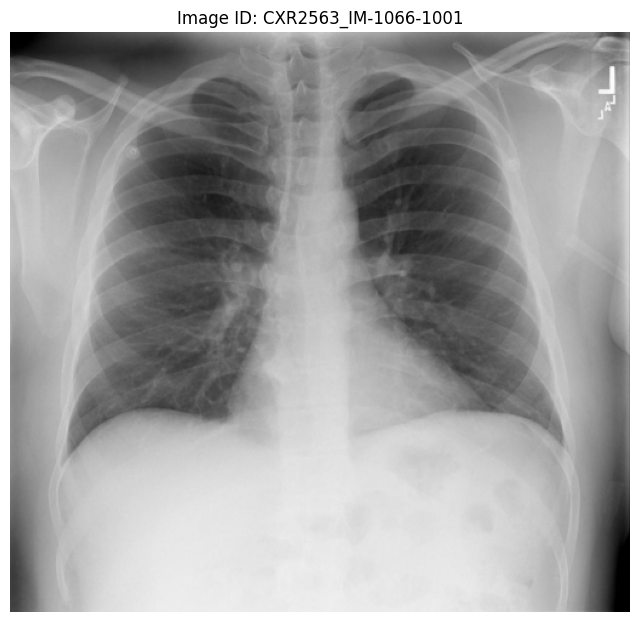

Image ID: CXR2563_IM-1066-1001

MeSH Terms: normal

Findings: The cardiomediastinal silhouette and pulmonary vasculature are within normal limits in size. The lungs are clear of focal airspace disease, pneumothorax, or pleural effusion. There are no acute bony findings.

Impression: No acute cardiopulmonary findings. .




In [52]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from tqdm.notebook import tqdm
from collections import Counter
import xml.etree.ElementTree as ET
from PIL import Image
import random

def parse_report(xml_path):
    try:
        tree = ET.parse(xml_path)
        root = tree.getroot()
        
        # Extract MeSH terms (medical conditions)
        mesh_terms = []
        for mesh in root.findall(".//MeSH/major"):
            if mesh.text:
                mesh_terms.append(mesh.text)
                
        # Extract findings section with improved redaction pattern
        findings_text = ""
        findings = root.find(".//AbstractText[@Label='FINDINGS']")
        if findings is not None and findings.text:
            findings_text = findings.text.strip()
            # Improved regex for any sequence of X's or x's
            findings_text = re.sub(r'[Xx][Xx]+', '[REDACTED]', findings_text)
        
        # Extract impression section with improved redaction
        impression_text = ""
        impression = root.find(".//AbstractText[@Label='IMPRESSION']")
        if impression is not None and impression.text:
            impression_text = impression.text.strip()
            # Same improved regex
            impression_text = re.sub(r'[Xx][Xx]+', '[REDACTED]', impression_text)
        
        # Get image IDs associated with this report
        image_ids = []
        for parent_image in root.findall(".//parentImage"):
            if parent_image.get('id'):
                image_ids.append(parent_image.get('id'))
        
        # Combine findings and impression for full report
        full_report = ""
        if findings_text:
            full_report += "FINDINGS: " + findings_text
        if impression_text:
            if full_report:
                full_report += " "
            full_report += "IMPRESSION: " + impression_text
        
        full_report = full_report.strip()
        
        return {
            'mesh_terms': mesh_terms,
            'findings': findings_text,
            'impression': impression_text,
            'full_report': full_report,
            'image_ids': image_ids
        }
    except Exception as e:
        print(f"Error parsing {xml_path}: {e}")
        return None

# 2. Create and explore dataset with comprehensive analysis
def create_dataset_df():
    """Create a DataFrame with image-report pairs and perform comprehensive analysis."""
    # Get list of all image files
    image_files = [f for f in os.listdir(IMAGE_DIR) if f.endswith('.png')]
    image_ids = [os.path.splitext(f)[0] for f in image_files]
    image_paths = [os.path.join(IMAGE_DIR, f) for f in image_files]
    
    # Get list of all report files
    report_files = [f for f in os.listdir(REPORT_DIR) if f.endswith('.xml')]
    
    print(f"Found {len(image_files)} images and {len(report_files)} reports")
    
    # Create image dictionary for quick lookup
    image_dict = {img_id: img_path for img_id, img_path in zip(image_ids, image_paths)}
    
    # Parse reports to find image-report pairs
    data = []
    
    for report_file in tqdm(report_files, desc="Processing reports"):
        report_path = os.path.join(REPORT_DIR, report_file)
        report_data = parse_report(report_path)
        
        if report_data:
            # Create entries for each image linked to this report
            for img_id in report_data['image_ids']:
                if img_id in image_dict:
                    item = {
                        'image_id': img_id,
                        'image_path': image_dict[img_id],
                        'report_path': report_path,
                        'mesh_terms': report_data['mesh_terms'],
                        'findings': report_data['findings'],
                        'impression': report_data['impression'],
                        'full_report': report_data['full_report']
                    }
                    data.append(item)
    
    # Create DataFrame
    df = pd.DataFrame(data)
    print(f"Created DataFrame with {len(df)} image-report pairs")
    
    # Calculate text lengths
    df['findings_word_count'] = df['findings'].apply(lambda x: len(x.split()) if x else 0)
    df['impression_word_count'] = df['impression'].apply(lambda x: len(x.split()) if x else 0)
    df['full_report_word_count'] = df['full_report'].apply(lambda x: len(x.split()) if x else 0)
    
    return df

# 3. Analyze and display dataset statistics
def analyze_dataset(df):
    """Perform comprehensive analysis of the dataset."""
    print("\n=== Dataset Statistics ===")
    
    # Missing and empty values
    print("\nMissing values in dataset:")
    print(df.isnull().sum())
    
    print("\nEmpty text fields:")
    print(f"Empty findings: {(df['findings'] == '').sum()} ({(df['findings'] == '').sum()/len(df)*100:.1f}%)")
    print(f"Empty impression: {(df['impression'] == '').sum()} ({(df['impression'] == '').sum()/len(df)*100:.1f}%)")
    print(f"Empty full_report: {(df['full_report'] == '').sum()} ({(df['full_report'] == '').sum()/len(df)*100:.1f}%)")
    
    # Report completeness
    both_sections = ((df['findings'] != '') & (df['impression'] != '')).sum()
    only_findings = ((df['findings'] != '') & (df['impression'] == '')).sum()
    only_impression = ((df['findings'] == '') & (df['impression'] != '')).sum()
    neither = ((df['findings'] == '') & (df['impression'] == '')).sum()
    
    print("\nReport completeness:")
    print(f"Reports with both findings and impression: {both_sections} ({both_sections/len(df)*100:.1f}%)")
    print(f"Reports with only findings: {only_findings} ({only_findings/len(df)*100:.1f}%)")
    print(f"Reports with only impression: {only_impression} ({only_impression/len(df)*100:.1f}%)")
    print(f"Reports with neither section: {neither} ({neither/len(df)*100:.1f}%)")
    
    # Text length statistics
    print("\nFindings word count:")
    print(df['findings_word_count'].describe())
    
    print("\nImpression word count:")
    print(df['impression_word_count'].describe())
    
    print("\nFull report word count:")
    print(df['full_report_word_count'].describe())
    
    # Images per report
    report_counts = df['report_path'].value_counts()
    images_per_report = report_counts.value_counts()
    
    print("\nNumber of images per report:")
    for num_images, count in images_per_report.items():
        print(f"{num_images} image(s): {count} reports")
    
    # MeSH terms statistics
    mesh_term_counts = df.apply(lambda x: len(x['mesh_terms']) if isinstance(x['mesh_terms'], list) else 0, axis=1)
    print("\nMeSH terms per image:")
    print(mesh_term_counts.describe())
    
    return df

# 4. Visualize dataset characteristics
def visualize_dataset(df):
    """Create visualizations for dataset characteristics."""
    # 1. Report completeness pie chart
    both_sections = ((df['findings'] != '') & (df['impression'] != '')).sum()
    only_findings = ((df['findings'] != '') & (df['impression'] == '')).sum()
    only_impression = ((df['findings'] == '') & (df['impression'] != '')).sum()
    neither = ((df['findings'] == '') & (df['impression'] == '')).sum()
    
    labels = ['Both sections', 'Only findings', 'Only impression', 'Neither section']
    sizes = [both_sections, only_findings, only_impression, neither]
    colors = ['#66b3ff', '#99ff99', '#ffcc99', '#ff9999']
    
    plt.figure(figsize=(10, 7))
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    plt.axis('equal')
    plt.title('Report Completeness')
    plt.show()
    
    # 2. Word count distributions
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.hist(df['findings_word_count'], bins=20)
    plt.title('Findings Word Count')
    plt.xlabel('Word Count')
    plt.ylabel('Frequency')
    
    plt.subplot(1, 3, 2)
    plt.hist(df['impression_word_count'], bins=20)
    plt.title('Impression Word Count')
    plt.xlabel('Word Count')
    
    plt.subplot(1, 3, 3)
    plt.hist(df['full_report_word_count'], bins=20)
    plt.title('Full Report Word Count')
    plt.xlabel('Word Count')
    
    plt.tight_layout()
    plt.show()
    
    # 3. Distribution of images per report
    report_counts = df['report_path'].value_counts()
    images_per_report = report_counts.value_counts()
    
    plt.figure(figsize=(10, 5))
    plt.bar(images_per_report.index, images_per_report.values)
    plt.title('Distribution of Images per Report')
    plt.xlabel('Number of Images')
    plt.ylabel('Number of Reports')
    plt.xticks(images_per_report.index)
    plt.grid(axis='y', alpha=0.3)
    plt.show()
    
    # 4. Top MeSH terms
    all_mesh_terms = []
    for terms in df['mesh_terms']:
        if isinstance(terms, list):
            all_mesh_terms.extend(terms)
    
    mesh_counter = Counter(all_mesh_terms)
    top_terms = [term for term, _ in mesh_counter.most_common(15)]
    top_counts = [count for _, count in mesh_counter.most_common(15)]
    
    plt.figure(figsize=(12, 6))
    plt.barh(top_terms, top_counts)
    plt.title('Top 15 Medical Conditions in the Dataset')
    plt.xlabel('Count')
    plt.ylabel('Medical Condition')
    plt.tight_layout()
    plt.show()

# 5. Analyze medical vocabulary
def analyze_medical_vocabulary(df):
    def process_text(text):
        if not text:
            return []
        
        # Lowercase and split into words
        words = text.lower().split()
        
        # Remove punctuation and common stop words
        stop_words = {'the', 'and', 'is', 'in', 'to', 'of', 'for', 'a', 'with', 'no', 'are', 
                     'on', 'or', 'as', 'by', 'there', 'at', 'be', 'this', 'that', 'an', 'from'}
        
        processed = []
        for word in words:
            word = word.strip('.,;:()[]{}!?-"\'')
            if word and word not in stop_words and not word.isdigit():
                processed.append(word)
        
        return processed
    
    # Process findings and impressions
    all_findings_words = []
    all_impression_words = []
    
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Processing medical vocabulary"):
        all_findings_words.extend(process_text(row['findings']))
        all_impression_words.extend(process_text(row['impression']))
    
    # Count frequencies
    findings_counter = Counter(all_findings_words)
    impression_counter = Counter(all_impression_words)
    
    # Display top medical terms
    print("\nTop 20 Words in Findings:")
    for word, count in findings_counter.most_common(20):
        print(f"{word}: {count}")
    
    print("\nTop 20 Words in Impressions:")
    for word, count in impression_counter.most_common(20):
        print(f"{word}: {count}")
    
    # Plot top terms
    plt.figure(figsize=(15, 10))
    
    plt.subplot(1, 2, 1)
    words, counts = zip(*findings_counter.most_common(15))
    plt.barh(words, counts)
    plt.title('Top Words in Findings')
    plt.xlabel('Count')
    
    plt.subplot(1, 2, 2)
    words, counts = zip(*impression_counter.most_common(15))
    plt.barh(words, counts)
    plt.title('Top Words in Impressions')
    plt.xlabel('Count')
    
    plt.tight_layout()
    plt.show()

# 6. Display sample data with images
def display_samples(df, num_samples=3):
    """Display random samples with images and reports."""
    if len(df) == 0:
        print("No data available to display")
        return
    
    # Select random samples
    sample_indices = random.sample(range(len(df)), min(num_samples, len(df)))
    
    for idx in sample_indices:
        row = df.iloc[idx]
        
        # Display image
        try:
            img = Image.open(row['image_path'])
            plt.figure(figsize=(8, 8))
            plt.imshow(img, cmap='gray')
            plt.title(f"Image ID: {row['image_id']}")
            plt.axis('off')
            plt.show()
            
            # Display report text
            print(f"Image ID: {row['image_id']}")
            print("\nMeSH Terms:", ', '.join(row['mesh_terms']) if isinstance(row['mesh_terms'], list) else row['mesh_terms'])
            print("\nFindings:", row['findings'] if row['findings'] else "None")
            print("\nImpression:", row['impression'] if row['impression'] else "None")
            print("\n" + "="*80 + "\n")
        except Exception as e:
            print(f"Error displaying sample {idx}: {e}")

# Execute all functions
# 1. Create the dataset
dataset_df = create_dataset_df()

# 2. Analyze the dataset
dataset_df = analyze_dataset(dataset_df)

# 3. Visualize the dataset
visualize_dataset(dataset_df)

# 4. Analyze medical vocabulary
analyze_medical_vocabulary(dataset_df)

# 5. Display samples
print("\nDisplaying random samples from the dataset:")
display_samples(dataset_df, num_samples=20)

## Data Analysis and Preparation for Modeling


=== MeSH Terms and Report Content Analysis ===

Reports with no findings: 997

Top MeSH terms in reports with no findings:
normal: 350
Cardiomegaly/mild: 46
Lung/hypoinflation: 43
Technical Quality of Image Unsatisfactory : 41
Aorta/tortuous: 38
Cardiomegaly: 37
Lung/hyperdistention: 33
Calcinosis/aorta: 29
Markings/bronchovascular: 21
Aorta/tortuous/mild: 21

Reports labeled as 'normal': 2696 (36.1%)

Most common words in 'normal' reports:
are: 3188
no: 3075
the: 2960
normal: 2802
is: 2115
or: 1794
and: 1786
pneumothorax: 1779
pleural: 1718
lungs: 1616
effusion: 1570
clear: 1414
size: 1379
heart: 1368
focal: 1234

=== Image-Report Matching Quality Check ===

Report with 2 images:
MeSH Terms: normal
Findings: The cardiomediastinal silhouette is within normal limits for size and contour. The lungs are normally inflated without evidence of focal airspace disease, pleural effusion, or pneumothorax. Osseous structures are within normal limits for patient age..
Impression: 1. No acute radi

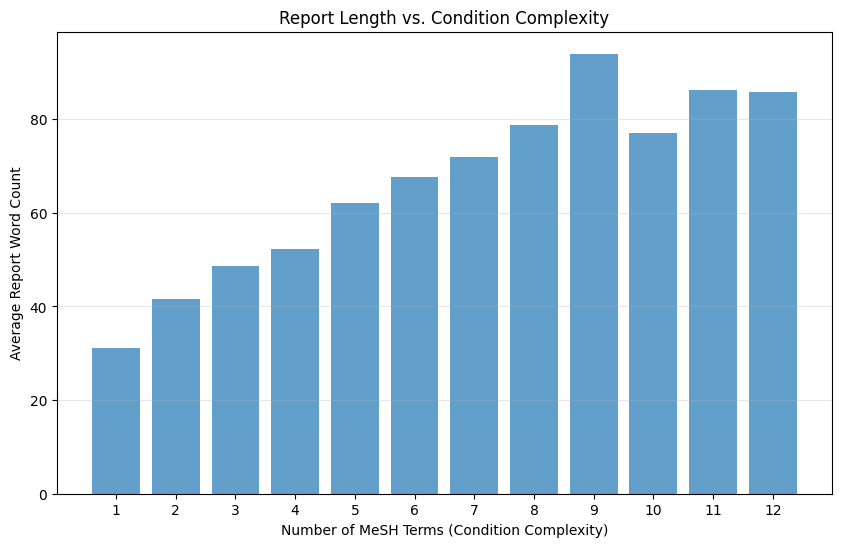

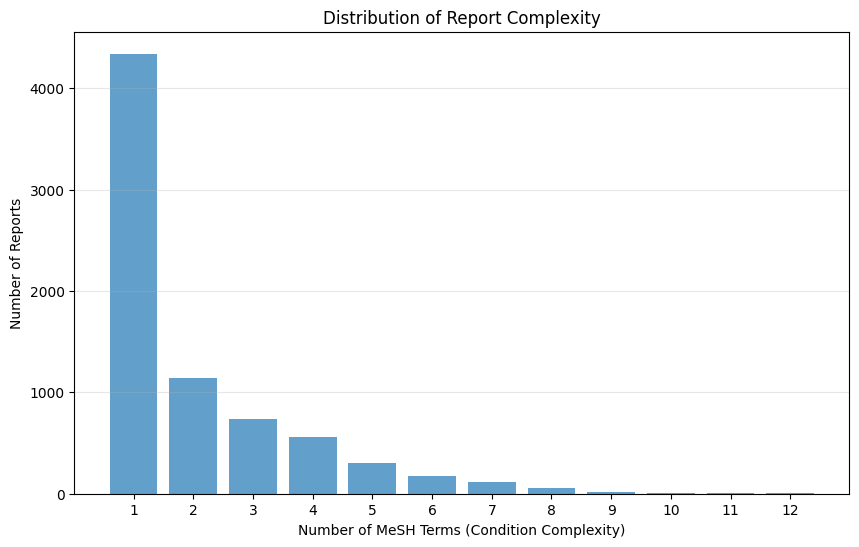

In [53]:

# 1. Analyze the relationship between MeSH terms and report content
def analyze_mesh_report_relationship(df):
    """Analyze how MeSH terms relate to the actual report content."""
    print("\n=== MeSH Terms and Report Content Analysis ===")
    
    # Check missing findings with MeSH terms
    reports_no_findings = df[df['findings'] == '']
    mesh_terms_no_findings = []
    for mesh_list in reports_no_findings['mesh_terms']:
        if isinstance(mesh_list, list):
            mesh_terms_no_findings.extend(mesh_list)
    
    print(f"\nReports with no findings: {len(reports_no_findings)}")
    mesh_counter_no_findings = Counter(mesh_terms_no_findings)
    print("\nTop MeSH terms in reports with no findings:")
    for term, count in mesh_counter_no_findings.most_common(10):
        print(f"{term}: {count}")
    
    # Check common patterns in "normal" labeled images
    normal_reports = df[df['mesh_terms'].apply(lambda x: 'normal' in x if isinstance(x, list) else False)]
    print(f"\nReports labeled as 'normal': {len(normal_reports)} ({len(normal_reports)/len(df)*100:.1f}%)")
    
    # Look at word frequency in "normal" reports
    normal_findings_words = []
    for finding in normal_reports['findings']:
        if finding:
            words = finding.lower().split()
            words = [w.strip('.,;:()[]{}!?-"\'') for w in words]
            normal_findings_words.extend([w for w in words if w])
    
    normal_counter = Counter(normal_findings_words)
    print("\nMost common words in 'normal' reports:")
    for word, count in normal_counter.most_common(15):
        print(f"{word}: {count}")
    
    return df

# 2. Check the quality of the image-report matching
def check_image_report_quality(df, num_samples=5):
    """Check the quality of image-report matching with random samples."""
    print("\n=== Image-Report Matching Quality Check ===")
    
    # Sample reports with multiple images
    multi_image_reports = df['report_path'].value_counts()
    multi_image_reports = multi_image_reports[multi_image_reports > 1].index.tolist()
    
    if not multi_image_reports:
        print("No reports with multiple images found")
        return
    
    sample_reports = random.sample(multi_image_reports, min(num_samples, len(multi_image_reports)))
    
    for report_path in sample_reports:
        images = df[df['report_path'] == report_path]
        print(f"\nReport with {len(images)} images:")
        print(f"MeSH Terms: {', '.join(images.iloc[0]['mesh_terms']) if isinstance(images.iloc[0]['mesh_terms'], list) else images.iloc[0]['mesh_terms']}")
        print(f"Findings: {images.iloc[0]['findings']}")
        print(f"Impression: {images.iloc[0]['impression']}")
        
        print("\nImage IDs associated with this report:")
        for idx, row in images.iterrows():
            print(f"- {row['image_id']}")
        
        print("-" * 80)

# 3. Analyze the "empty" reports to understand the data quality
def analyze_empty_reports(df):
    """Analyze reports with missing sections."""
    print("\n=== Analysis of Reports with Missing Sections ===")
    
    # Reports with empty findings
    empty_findings = df[df['findings'] == '']
    print(f"\nReports with empty findings: {len(empty_findings)} ({len(empty_findings)/len(df)*100:.1f}%)")
    
    # Check if these reports have impressions
    findings_empty_impression_present = empty_findings[empty_findings['impression'] != '']
    print(f"Reports with empty findings but with impressions: {len(findings_empty_impression_present)} ({len(findings_empty_impression_present)/len(empty_findings)*100:.1f}% of empty findings)")
    
    # Reports with empty impressions
    empty_impression = df[df['impression'] == '']
    print(f"\nReports with empty impressions: {len(empty_impression)} ({len(empty_impression)/len(df)*100:.1f}%)")
    
    # Check if these reports have findings
    impression_empty_findings_present = empty_impression[empty_impression['findings'] != '']
    print(f"Reports with empty impressions but with findings: {len(impression_empty_findings_present)} ({len(impression_empty_findings_present)/len(empty_impression)*100:.1f}% of empty impressions)")
    
    # Reports with completely empty text
    completely_empty = df[(df['findings'] == '') & (df['impression'] == '')]
    print(f"\nReports with both sections empty: {len(completely_empty)} ({len(completely_empty)/len(df)*100:.1f}%)")
    
    return df

# 4. Extract common patterns in the reports for feature engineering
def extract_report_patterns(df):
    print("\n=== Common Report Patterns ===")
    
    # Extract common phrases in findings
    findings_phrases = []
    for finding in df['findings']:
        if finding:
            # Split into sentences
            sentences = finding.split('.')
            for sentence in sentences:
                if len(sentence.strip()) > 10:  # Ignore very short sentences
                    findings_phrases.append(sentence.strip())
    
    # Count phrase frequencies (simplified approach)
    findings_phrase_counter = Counter(findings_phrases)
    
    print("\nCommon phrases in findings:")
    for phrase, count in findings_phrase_counter.most_common(10):
        if count > 50:  # Only show phrases that appear frequently
            print(f"- {phrase}: {count}")
    
    # Look for common structures in impressions
    impression_starts = []
    for impression in df['impression']:
        if impression:
            words = impression.split()
            if len(words) >= 3:
                impression_starts.append(' '.join(words[:3]))
    
    impression_start_counter = Counter(impression_starts)
    
    print("\nCommon ways to start impressions:")
    for start, count in impression_start_counter.most_common(10):
        if count > 20:
            print(f"- {start}...: {count}")
    
    return df

# 5. Analyze cases where findings and impression have different information
def analyze_findings_impression_differences(df):
    """Analyze cases where findings and impression sections contain different information."""
    print("\n=== Findings vs Impression Content Analysis ===")
    
    # Create a function to extract key medical terms
    def extract_medical_terms(text):
        if not text:
            return set()
        
        # List of common medical terms from our previous analysis
        medical_terms = {
            'pneumothorax', 'effusion', 'consolidation', 'cardiomegaly', 'edema',
            'emphysema', 'atelectasis', 'pneumonia', 'opacity', 'granuloma',
            'calcification', 'fracture', 'nodule', 'mass', 'pleural', 'infiltrate'
        }
        
        found_terms = set()
        text_lower = text.lower()
        
        for term in medical_terms:
            if term in text_lower:
                found_terms.add(term)
        
        return found_terms
    
    # Compare terms in findings vs impression
    different_info_count = 0
    impression_terms_not_in_findings = Counter()
    
    for idx, row in df.iterrows():
        if row['findings'] and row['impression']:
            findings_terms = extract_medical_terms(row['findings'])
            impression_terms = extract_medical_terms(row['impression'])
            
            # Terms in impression but not in findings
            diff_terms = impression_terms - findings_terms
            
            if diff_terms:
                different_info_count += 1
                for term in diff_terms:
                    impression_terms_not_in_findings[term] += 1
    
    print(f"\nReports where impression contains terms not in findings: {different_info_count} ({different_info_count/len(df)*100:.1f}%)")
    
    print("\nCommon medical terms in impressions but not in findings:")
    for term, count in impression_terms_not_in_findings.most_common(10):
        print(f"- {term}: {count}")
    
    return df

# 6. Analyze report length vs. condition complexity
def analyze_report_complexity(df):
    """Analyze how report length relates to condition complexity."""
    print("\n=== Report Complexity Analysis ===")
    
    # Count number of MeSH terms per report
    df['mesh_term_count'] = df['mesh_terms'].apply(lambda x: len(x) if isinstance(x, list) else 0)
    
    # Group by mesh term count and get average word counts
    complexity_groups = df.groupby('mesh_term_count').agg({
        'findings_word_count': 'mean',
        'impression_word_count': 'mean',
        'full_report_word_count': 'mean',
        'image_id': 'count'
    }).reset_index()
    
    complexity_groups = complexity_groups.rename(columns={'image_id': 'count'})
    
    print("\nReport length by condition complexity (number of MeSH terms):")
    print(complexity_groups)
    
    # Plot relationship
    plt.figure(figsize=(10, 6))
    plt.bar(complexity_groups['mesh_term_count'], complexity_groups['full_report_word_count'], alpha=0.7)
    plt.xlabel('Number of MeSH Terms (Condition Complexity)')
    plt.ylabel('Average Report Word Count')
    plt.title('Report Length vs. Condition Complexity')
    plt.grid(axis='y', alpha=0.3)
    plt.xticks(complexity_groups['mesh_term_count'])
    plt.show()
    
    # Distribution of report complexity
    plt.figure(figsize=(10, 6))
    plt.bar(complexity_groups['mesh_term_count'], complexity_groups['count'], alpha=0.7)
    plt.xlabel('Number of MeSH Terms (Condition Complexity)')
    plt.ylabel('Number of Reports')
    plt.title('Distribution of Report Complexity')
    plt.grid(axis='y', alpha=0.3)
    plt.xticks(complexity_groups['mesh_term_count'])
    plt.show()
    
    return df

# Create dataset DataFrame if it doesn't exist yet
if 'dataset_df' not in locals():
    # First load or create the dataset
    # Get list of all image files
    image_files = [f for f in os.listdir(IMAGE_DIR) if f.endswith('.png')]
    image_ids = [os.path.splitext(f)[0] for f in image_files]
    image_paths = [os.path.join(IMAGE_DIR, f) for f in image_files]
    
    # Get list of all report files
    report_files = [f for f in os.listdir(REPORT_DIR) if f.endswith('.xml')]
    
    print(f"Found {len(image_files)} images and {len(report_files)} reports")
    
    # Create image dictionary for quick lookup
    image_dict = {img_id: img_path for img_id, img_path in zip(image_ids, image_paths)}
    
    # Parse reports to find image-report pairs
    data = []
    
    for report_file in tqdm(report_files, desc="Processing reports"):
        report_path = os.path.join(REPORT_DIR, report_file)
        report_data = parse_report(report_path)
        
        if report_data:
            # Create entries for each image linked to this report
            for img_id in report_data['image_ids']:
                if img_id in image_dict:
                    item = {
                        'image_id': img_id,
                        'image_path': image_dict[img_id],
                        'report_path': report_path,
                        'mesh_terms': report_data['mesh_terms'],
                        'findings': report_data['findings'],
                        'impression': report_data['impression'],
                        'full_report': report_data['full_report']
                    }
                    data.append(item)
    
    # Create DataFrame
    dataset_df = pd.DataFrame(data)
    
    # Calculate text lengths
    dataset_df['findings_word_count'] = dataset_df['findings'].apply(lambda x: len(x.split()) if x else 0)
    dataset_df['impression_word_count'] = dataset_df['impression'].apply(lambda x: len(x.split()) if x else 0)
    dataset_df['full_report_word_count'] = dataset_df['full_report'].apply(lambda x: len(x.split()) if x else 0)

dataset_df = analyze_mesh_report_relationship(dataset_df)
check_image_report_quality(dataset_df)
dataset_df = analyze_empty_reports(dataset_df)
dataset_df = extract_report_patterns(dataset_df)
dataset_df = analyze_findings_impression_differences(dataset_df)
dataset_df = analyze_report_complexity(dataset_df)

## global tokenizer

In [54]:
from transformers import GPT2Tokenizer
tokenizer_global = None

def initialize_global_tokenizer():
    """Initialize the global tokenizer with left-side padding."""
    global tokenizer_global
    tokenizer_global = GPT2Tokenizer.from_pretrained('gpt2')
    
    # Set padding configurations
    tokenizer_global.padding_side = 'left'
    tokenizer_global.pad_token = tokenizer_global.eos_token
    
    # Add special tokens
    special_tokens = {
        'additional_special_tokens': ['[FINDINGS]', '[IMPRESSION]', '<redacted>']
    }
    num_added = tokenizer_global.add_special_tokens(special_tokens)
    print(f"Added {num_added} special tokens to the tokenizer with left padding")
    
    return tokenizer_global

tokenizer_global = initialize_global_tokenizer()

Added 3 special tokens to the tokenizer with left padding


## Image / Report Preprocessing

In [55]:
import os
import torch
import pandas as pd
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import GPT2Tokenizer
import re
from sklearn.model_selection import train_test_split


# 1. Image Preprocessing Functions
def preprocess_image(image_path, transform=None):
    """Load and preprocess a single image."""
    if transform is None:
        # Default ResNet-50 preprocessing if no transform is provided
        transform = transforms.Compose([
            transforms.Resize((224, 224)),  # ResNet-50 input size
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],  # ImageNet mean
                std=[0.229, 0.224, 0.225]    # ImageNet std
            )
        ])
    
    try:
        image = Image.open(image_path).convert('RGB')
        return transform(image)
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        # Return a blank tensor in case of error
        return torch.zeros(3, 224, 224)

# 2. Text Processing Functions
def clean_text(text):
    """Clean the report text by removing special characters, etc."""
    if not isinstance(text, str):
        return ""
    
    # Replace [REDACTED] with a consistent token
    text = re.sub(r'\[REDACTED\]', '<redacted>', text)
    
    # Remove multiple spaces
    text = re.sub(r'\s+', ' ', text)
    
    # Strip and return
    return text.strip()

def preprocess_report(findings, impression, tokenizer=None, max_length=192):
    """Process report text using the global tokenizer."""
    global tokenizer_global
    
    # Use the global tokenizer if the passed one is invalid
    if tokenizer is None or not isinstance(tokenizer, GPT2Tokenizer):
        if tokenizer_global is None:
            tokenizer_global = initialize_global_tokenizer()
        tokenizer = tokenizer_global
    
    # Clean the text
    cleaned_findings = clean_text(findings) if isinstance(findings, str) else ""
    cleaned_impression = clean_text(impression) if isinstance(impression, str) else ""
    
    # Prepare text with a clear prefix prompt
    formatted_text = "Generate a chest X-ray report: "
    
    # Add findings and impression as appropriate
    if cleaned_findings and cleaned_impression:
        formatted_text = f"Findings on chest X-ray: The examination reveals [FINDINGS] {cleaned_findings} [IMPRESSION] {cleaned_impression}"
    elif cleaned_findings:
        formatted_text = f"Findings on chest X-ray: The examination reveals [FINDINGS] {cleaned_findings}"
    elif cleaned_impression:
        formatted_text = f"Findings on chest X-ray: The examination reveals [IMPRESSION] {cleaned_impression}"
    else:
        formatted_text = "Findings on chest X-ray: The examination reveals no significant abnormalities."
    
    # Tokenize with special handling for prefix
    try:
        encoding = tokenizer(
            formatted_text,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
    except Exception as e:
        print(f"Error tokenizing text: {e}")
        # Return empty tensors as fallback
        return {
            'input_ids': torch.zeros((max_length,), dtype=torch.long),
            'attention_mask': torch.zeros((max_length,), dtype=torch.long),
            'original_text': formatted_text
        }
    
    return {
        'input_ids': encoding['input_ids'].squeeze(),
        'attention_mask': encoding['attention_mask'].squeeze(),
        'original_text': formatted_text
    }

## XRayReportDataset Class
Custom dataset for X-ray images and their reports.

In [56]:

class XRayReportDataset(Dataset):
    
    def __init__(self, dataframe, tokenizer, image_dir, max_length=128, transform=None):
       
        self.dataframe = dataframe
        # Store tokenizer as an attribute, ensuring it's properly handled
        global tokenizer_global
        self.tokenizer = tokenizer_global if tokenizer_global is not None else tokenizer
        self.image_dir = image_dir
        self.max_length = max_length
        self.transform = transform
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        """Get a single data point."""
        row = self.dataframe.iloc[idx]
        
        # Get image path and process image
        image_path = row['image_path']
        image_tensor = preprocess_image(image_path, self.transform)
        
        # Process report text using the global tokenizer
        global tokenizer_global
        if not isinstance(self.tokenizer, GPT2Tokenizer) and tokenizer_global is not None:
            self.tokenizer = tokenizer_global
            
        report_data = preprocess_report(
            row['findings'],
            row['impression'], 
            self.tokenizer,
            self.max_length
        )
        
        return {
            'image': image_tensor,
            'input_ids': report_data['input_ids'],
            'attention_mask': report_data['attention_mask'],
            'original_text': report_data['original_text']
        }

## Data Loaders

In [57]:
def create_data_loaders(train_df, val_df, test_df, tokenizer, image_dir, batch_size=16):
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomAffine(
            degrees=5,
            translate=(0.05, 0.05),
            scale=(0.95, 1.05)
        ),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])
    
    # Define image transformations for validation and testing (no augmentation)
    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])
    
    # Store tokenizer in a global variable to ensure it's accessible
    global tokenizer_global
    tokenizer_global = tokenizer
    
    # Create datasets
    train_dataset = XRayReportDataset(train_df, tokenizer, image_dir, transform=train_transform)
    val_dataset = XRayReportDataset(val_df, tokenizer, image_dir, transform=val_transform)
    test_dataset = XRayReportDataset(test_df, tokenizer, image_dir, transform=val_transform)
    
    # Create data loaders with NO workers (avoid multiprocessing)
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True
    )
    val_loader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True
    )
    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True
    )
    
    return train_loader, val_loader, test_loader, train_dataset, val_dataset, test_dataset

def initialize_tokenizer():
    tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
    
    # Set padding token to be the EOS token
    tokenizer.pad_token = tokenizer.eos_token
    
    # Add special tokens for radiology domain
    special_tokens = {
        'additional_special_tokens': ['[FINDINGS]', '[IMPRESSION]', '<redacted>']
    }
    num_added = tokenizer.add_special_tokens(special_tokens)
    
    # Add a beginning of sequence token
    tokenizer.bos_token = tokenizer.cls_token if hasattr(tokenizer, 'cls_token') else tokenizer.eos_token
    
    print(f"Added {num_added} special tokens to the tokenizer")
    return tokenizer

## Training preprocessing

In [58]:

def prepare_data(dataset_df):
    """Main function to prepare the data for training with balanced sampling."""
    # Split the dataset
    train_df, temp_df = train_test_split(dataset_df, test_size=0.3, random_state=42)
    val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)
    
    print(f"Dataset split: {len(train_df)} training, {len(val_df)} validation, {len(test_df)} test")
    
    # Initialize tokenizer
    tokenizer = initialize_tokenizer()
    
    # Define image transformations
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomAffine(
            degrees=5,
            translate=(0.05, 0.05),
            scale=(0.95, 1.05)
        ),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])
    
    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])
    
    # Create datasets
    train_dataset = XRayReportDataset(train_df, tokenizer, IMAGE_DIR, transform=train_transform)
    val_dataset = XRayReportDataset(val_df, tokenizer, IMAGE_DIR, transform=val_transform)
    test_dataset = XRayReportDataset(test_df, tokenizer, IMAGE_DIR, transform=val_transform)
    
    is_normal = []
    for _, row in train_df.iterrows():
        text = row['findings'].lower() + ' ' + row['impression'].lower()
        if 'normal' in text or 'no acute' in text:
            is_normal.append(0)  # Normal
        else:
            is_normal.append(1)  # Abnormal
    
    # Calculate class weights
    class_sample_count = np.bincount(is_normal)
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[t] for t in is_normal])
    samples_weight = torch.from_numpy(samples_weight).float()
    
    # Create sampler
    train_sampler = torch.utils.data.WeightedRandomSampler(
        weights=samples_weight,
        num_samples=len(samples_weight),
        replacement=True
    )
    
    # Create data loaders with balanced sampling
    train_loader = DataLoader(
        train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler, 
        num_workers=0, pin_memory=True
    )
    val_loader = DataLoader(
        val_dataset, batch_size=BATCH_SIZE, shuffle=False, 
        num_workers=0, pin_memory=True
    )
    test_loader = DataLoader(
        test_dataset, batch_size=BATCH_SIZE, shuffle=False, 
        num_workers=0, pin_memory=True
    )
    
    global tokenizer_global
    tokenizer_global = tokenizer
    
    return {
        'train_loader': train_loader,
        'val_loader': val_loader,
        'test_loader': test_loader,
        'train_dataset': train_dataset,
        'val_dataset': val_dataset,
        'test_dataset': test_dataset,
        'tokenizer': tokenizer
    }

## ResNetGPT2 Encoder-Decoder model 
Encoder-Decoder model that combines ResNet-50 for image feature extraction
with GPT-2 for text generation.

In [59]:
import torch
import torch.nn as nn
from torchvision import models
from transformers import GPT2LMHeadModel, GPT2Config
from transformers import GPT2Tokenizer
tokenizer = None

class ResNetGPT2(nn.Module):
   
    
    def __init__(self, tokenizer, pretrained=True, freeze_encoder=True):
        super(ResNetGPT2, self).__init__()
        
        # 1. Initialize ResNet-50 encoder
        self.encoder = models.resnet50(pretrained=pretrained)
        
        # Remove the classification head
        self.encoder = nn.Sequential(*list(self.encoder.children())[:-1])
        
        # Freeze encoder weights if specified
        if freeze_encoder:
            for param in self.encoder.parameters():
                param.requires_grad = False
        
        # 2. Initialize GPT-2 decoder
        self.gpt2_config = GPT2Config.from_pretrained('gpt2')
        
        # Remove loss_type if it exists to prevent issues
        if hasattr(self.gpt2_config, 'loss_type'):
            delattr(self.gpt2_config, 'loss_type')
        
        # Update the config if tokenizer has added special tokens
        if tokenizer.vocab_size != self.gpt2_config.vocab_size:
            self.gpt2_config.vocab_size = tokenizer.vocab_size
        
        # Load GPT-2 model with updated config
        self.decoder = GPT2LMHeadModel.from_pretrained('gpt2', config=self.gpt2_config)
        
        # Resize token embeddings in case of added special tokens
        self.decoder.resize_token_embeddings(len(tokenizer))
        
        # 3. Create improved projection layers from ResNet features to GPT-2 embedding space
        # ResNet-50 outputs a 2048-dimensional vector
        resnet_output_dim = 2048
        
        # GPT-2 hidden dimension is 768 by default
        gpt2_input_dim = self.gpt2_config.n_embd
        
        # Create a projection layer with multiple stages for better transformation
        self.projection = nn.Sequential(
                nn.Linear(resnet_output_dim, 1024),
                nn.LayerNorm(1024),
                nn.Dropout(0.2),  # Increased dropout
                nn.ReLU(),
                nn.Linear(1024, gpt2_input_dim),
                nn.LayerNorm(gpt2_input_dim),
                nn.Dropout(0.2)   # Increased dropout
            )
        
        # Initialize weights for better training
        for m in self.projection.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, images, input_ids, attention_mask=None, labels=None):
        """Forward pass with stronger visual feature integration."""
        batch_size = images.size(0)
        seq_length = input_ids.size(1)
        
        # Extract visual features
        visual_features = self.encoder(images)
        visual_features = visual_features.view(batch_size, -1)
        
        # Project to GPT-2 space
        projected_features = self.projection(visual_features)
        
        # Get word embeddings
        inputs_embeds = self.decoder.transformer.wte(input_ids)
        
        # Get position embeddings
        position_ids = torch.arange(0, seq_length, dtype=torch.long, device=input_ids.device)
        position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
        position_embeds = self.decoder.transformer.wpe(position_ids)
        
        # Apply visual features to multiple tokens at the beginning (first 3 tokens)
        for i in range(batch_size):
            # Stronger conditioning on the first token
            inputs_embeds[i, 0, :] = inputs_embeds[i, 0, :] + 2.0 * projected_features[i]
            
            # Weaker conditioning on subsequent tokens
            if seq_length > 1:
                inputs_embeds[i, 1, :] = inputs_embeds[i, 1, :] + 0.5 * projected_features[i]
            if seq_length > 2:
                inputs_embeds[i, 2, :] = inputs_embeds[i, 2, :] + 0.3 * projected_features[i]
        
        # Combine with position embeddings
        hidden_states = inputs_embeds + position_embeds
        
        # Forward through GPT-2
        model_inputs = {
            'inputs_embeds': hidden_states,
            'attention_mask': attention_mask,
            'past_key_values': None,
            'labels': labels,
            'use_cache': False,
            'return_dict': True
        }
        
        outputs = self.decoder(**model_inputs)
        return outputs
    
    def generate(self, images, tokenizer, max_length=120, num_beams=3, early_stopping=True):
        """Generate text with more diverse outputs."""
        batch_size = images.size(0)
    
        # Extract visual features
        visual_features = self.encoder(images)
        visual_features = visual_features.view(batch_size, -1)
        
        # Project to GPT-2 space
        projected_features = self.projection(visual_features)
        
        # Choose a more specific radiology prompt
        prompts = [
            "Chest X-ray Report:",
            "Findings on chest X-ray:",
            "Chest radiograph reveals:",
            "X-ray examination shows:"
        ]
        
        generated_texts = []
        
        for i in range(batch_size):
            prompt = random.choice(prompts)
            prompt_ids = tokenizer.encode(prompt, return_tensors="pt").to(images.device)
            
            # Create attention mask for the prompt
            prompt_attention_mask = torch.ones_like(prompt_ids)
            
            # Get embeddings for the prompt
            inputs_embeds = self.decoder.transformer.wte(prompt_ids)
            
            # Inject image features into the prompt embedding more strongly
            inputs_embeds[0, 0, :] += 2.0 * projected_features[i]
            
            # Use a more diverse generation strategy
            with torch.no_grad():
                # Randomly choose between diverse beams and sampling
                if random.random() < 0.7:  # Bias toward sampling for diversity
                    # Sampling with higher temperature
                    generated = self.decoder.generate(
                        input_ids=prompt_ids,
                        attention_mask=prompt_attention_mask,
                        pad_token_id=tokenizer.pad_token_id,
                        eos_token_id=tokenizer.eos_token_id,
                        max_length=max_length,
                        num_beams=4,
                        temperature=1.2,  # Higher temperature
                        top_p=0.92, 
                        top_k=50,
                        repetition_penalty=2.0,  # Increased penalty
                        length_penalty=1.0,
                        no_repeat_ngram_size=3,
                        do_sample=True,
                        early_stopping=early_stopping,
                    )
                else:
                    # Diverse beam search with proper beam group values
                    # Make sure num_beams is divisible by num_beam_groups
                    num_beams = 6  # 6 is divisible by 2 and 3
                    num_beam_groups = 3
                    
                    generated = self.decoder.generate(
                        input_ids=prompt_ids,
                        attention_mask=prompt_attention_mask,
                        pad_token_id=tokenizer.pad_token_id,
                        eos_token_id=tokenizer.eos_token_id,
                        max_length=max_length,
                        num_beams=num_beams,
                        num_beam_groups=num_beam_groups, 
                        diversity_penalty=1.0,
                        length_penalty=1.0,
                        no_repeat_ngram_size=3,
                        do_sample=False,
                        early_stopping=early_stopping,
                    )
            
            # Process generated text
            text = tokenizer.decode(generated[0], skip_special_tokens=True)
            # Clean up the text to remove the prompt
            if prompt in text:
                text = text.replace(prompt, "").strip()
                
            # Post-process to reduce generic outputs
            if "No acute cardiopulmonary abnormality" in text:
                # Only keep this phrase if it appears at most once
                text = text.replace("No acute cardiopulmonary abnormality.", 
                                  "The examination reveals:", 1)
            
            generated_texts.append(text)
        
        return generated_texts

## Training and Evaluation Pipeline


[nltk_data] Downloading package punkt to /home/ubuntu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ubuntu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/home/ubuntu/dl/dl-env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/dl/dl-env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using device: cuda
Loading checkpoint from ./IUXRAY_OUTPUT_PIPELINE/checkpoints/latest_checkpoint.pth
Checkpoint loaded successfully with non-strict loading

Evaluating on test set...
Loading checkpoint from ./IUXRAY_OUTPUT_PIPELINE/checkpoints/best_bleu_model.pth
Checkpoint loaded successfully with non-strict loading


[VALID]:   0%|          | 0/71 [00:00<?, ?it/s]


Batch 0 samples:
Ref: No change lung <redacted>. <redacted> opacities are present in the right lower lobe. No focal infilt...
Gen: The lungs are clear. There is no pleural effusion or pneumothorax. Heart and mediastinum are within ...
Ref: Lungs are clear bilaterally. Cardiac and mediastinal silhouettes are normal. Pulmonary vasculature i...
Gen: The heart and mediastinum are within normal limits. No focal alveolar consolidation, pleural effusio...

Batch 1 samples:
Ref: Heart size normal. No pneumothorax, pleural effusion, or focal airspace disease. Nodular densities c...
Gen: The heart is mildly enlarged. The lungs are clear. There is no pleural effusion or pneumothorax.  Th...
Ref: Lungs are clear. No pleural effusions or pneumothoraces. Heart and mediastinum of normal size and co...
Gen: The examination reveals: No evidence of active tuberculous process. Stable cardiomegaly. No  of pleu...

Batch 2 samples:
Ref: The heart size and cardiomediastinal silhouette are normal. There is 

[VALID]:   0%|          | 0/71 [00:00<?, ?it/s]


Batch 0 samples:
Ref: No change lung <redacted>. <redacted> opacities are present in the right lower lobe. No focal infilt...
Gen: The cardiac silhouette is normal in size and contour. The mediastinum is unremarkable. The lungs are...
Ref: Lungs are clear bilaterally. Cardiac and mediastinal silhouettes are normal. Pulmonary vasculature i...
Gen: The examination reveals  The heart is normal in size and contour. The lungs are clear. There is no p...

Batch 1 samples:
Ref: Heart size normal. No pneumothorax, pleural effusion, or focal airspace disease. Nodular densities c...
Gen: The heart is normal in size and contour. The mediastinum is unremarkable. The lungs are clear. There...
Ref: Lungs are clear. No pleural effusions or pneumothoraces. Heart and mediastinum of normal size and co...
Gen: The examination reveals  The cardiac silhouette is normal in size and contour. There is no pneumotho...

Batch 2 samples:
Ref: The heart size and cardiomediastinal silhouette are normal. There is 

/home/ubuntu/dl/dl-env/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:677: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Medical condition detection:
  Normal: F1=0.8898, P=0.8775, R=0.9024
  Cardiomegaly: F1=0.1256, P=0.0693, R=0.6667
  Effusion: F1=0.8504, P=0.7491, R=0.9834
  Pneumothorax: F1=0.7755, P=0.6467, R=0.9683
  Opacity: F1=0.0575, P=0.0746, R=0.0467
  Edema: F1=0.0728, P=0.0582, R=0.0973
Using ROUGE-optimized model for final results

Test Metrics:
  bleu-1: 0.2795
  bleu-2: 0.1589
  bleu-3: 0.1026
  bleu-4: 0.0679
  rouge-1: 0.2944
  rouge-2: 0.0951
  rouge-l: 0.1992
  val_loss: 1.0506
  condition_results:
    normal:
      precision: 0.8775
      recall: 0.9024
      f1: 0.8898
    cardiomegaly:
      precision: 0.0693
      recall: 0.6667
      f1: 0.1256
    effusion:
      precision: 0.7491
      recall: 0.9834
      f1: 0.8504
    pneumothorax:
      precision: 0.6467
      recall: 0.9683
      f1: 0.7755
    opacity:
      precision: 0.0746
      recall: 0.0467
      f1: 0.0575
    edema:
      precision: 0.0582
      recall: 0.0973
      f1: 0.0728


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generati

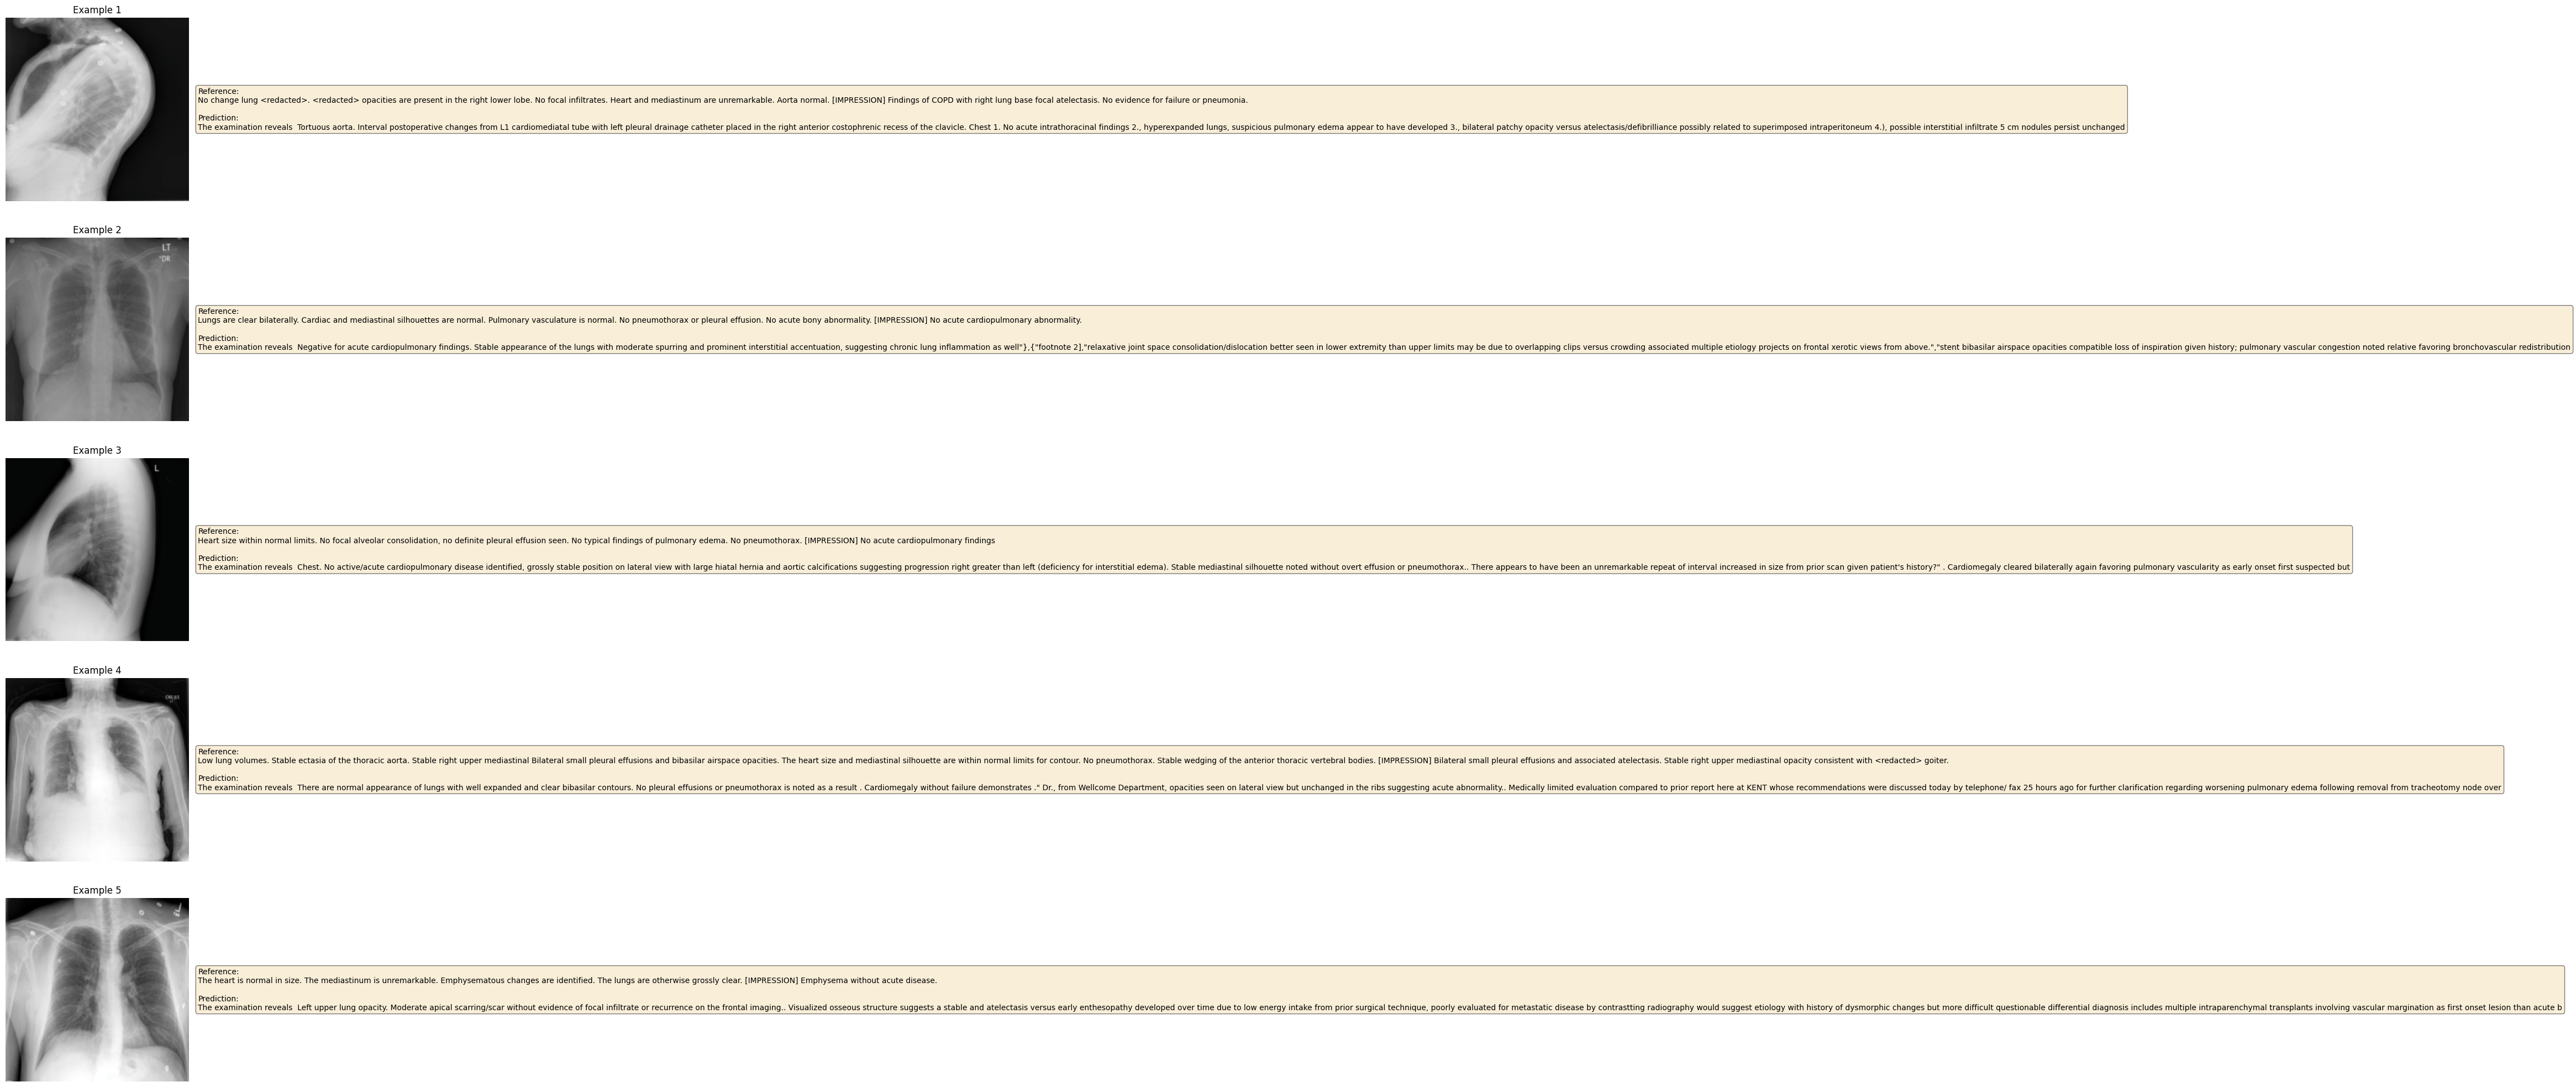

Training and evaluation completed!


In [47]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
import time
import numpy as np
from sklearn.metrics import accuracy_score
import nltk
from nltk.translate.bleu_score import corpus_bleu
from rouge_score import rouge_scorer  # Change this import
import matplotlib.pyplot as plt
import os
import json
from datetime import datetime
from skimage.metrics import structural_similarity as ssim
import cv2

# Download required NLTK resources
nltk.download('punkt')
nltk.download('wordnet')


LEARNING_RATE = 5e-5  
BATCH_SIZE = 16  
NUM_EPOCHS = 40 
EARLY_STOPPING_PATIENCE = 10  
MAX_TEXT_LENGTH = 192
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


print(f"Using device: {DEVICE}")

# Checkpoint handling functions
def save_checkpoint(model, optimizer, epoch, metrics, filename):
    """Save a checkpoint with model state, optimizer state, and metrics."""
    # Save checkpoint
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'metrics': metrics,
    }, filename)
    print(f"Checkpoint saved to {filename}")
    
    checkpoint_dir = os.path.dirname(filename)
    if 'checkpoint_epoch_' in filename:
        current_epoch_num = int(filename.split('checkpoint_epoch_')[1].split('.')[0])
        for old_epoch in range(1, current_epoch_num):
            old_checkpoint = os.path.join(checkpoint_dir, f'checkpoint_epoch_{old_epoch}.pth')
            if os.path.exists(old_checkpoint):
                os.remove(old_checkpoint)
                print(f"Removed old checkpoint: {old_checkpoint}")

def load_checkpoint(model, optimizer, filename):
    """Load a checkpoint and return the epoch and metrics."""
    if os.path.isfile(filename):
        print(f"Loading checkpoint from {filename}")
        try:
            checkpoint = torch.load(filename, map_location=DEVICE)
            model.load_state_dict(checkpoint['model_state_dict'], strict=False) 
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            print("Checkpoint loaded successfully with non-strict loading")
            return checkpoint['epoch'], checkpoint['metrics']
        except Exception as e:
            print(f"Error loading checkpoint: {e}")
            print("Starting from scratch since model architecture has changed.")
            return 0, {}  # Return empty dict for metrics
    else:
        print(f"No checkpoint found at {filename}")
        return 0, {}  # Return empty dict for metrics

# Metrics calculation functions
def calculate_metrics(predictions, references):
    """Calculate BLEU and ROUGE metrics."""
    metrics = {}
    
    # Tokenize predictions and references
    tokenized_preds = [nltk.word_tokenize(pred.lower()) for pred in predictions]
    tokenized_refs = [nltk.word_tokenize(ref.lower()) for ref in references]
    
    # Format for corpus_bleu
    references_for_bleu = [[ref] for ref in tokenized_refs]
    
    # Calculate BLEU scores
    try:
        metrics['bleu-1'] = corpus_bleu(references_for_bleu, tokenized_preds, weights=(1, 0, 0, 0))
        metrics['bleu-2'] = corpus_bleu(references_for_bleu, tokenized_preds, weights=(0.5, 0.5, 0, 0))
        metrics['bleu-3'] = corpus_bleu(references_for_bleu, tokenized_preds, weights=(0.33, 0.33, 0.33, 0))
        metrics['bleu-4'] = corpus_bleu(references_for_bleu, tokenized_preds, weights=(0.25, 0.25, 0.25, 0.25))
    except Exception as e:
        print(f"Error calculating BLEU scores: {e}")
        metrics['bleu-1'] = metrics['bleu-2'] = metrics['bleu-3'] = metrics['bleu-4'] = 0.0
    
    # Calculate ROUGE scores using rouge_score library
    try:
        scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
        rouge_scores = {'rouge-1': 0, 'rouge-2': 0, 'rouge-l': 0}
        
        for pred, ref in zip(predictions, references):
            score = scorer.score(ref, pred)
            rouge_scores['rouge-1'] += score['rouge1'].fmeasure
            rouge_scores['rouge-2'] += score['rouge2'].fmeasure
            rouge_scores['rouge-l'] += score['rougeL'].fmeasure
        
        # Calculate averages
        n = len(predictions)
        metrics['rouge-1'] = rouge_scores['rouge-1'] / n if n > 0 else 0
        metrics['rouge-2'] = rouge_scores['rouge-2'] / n if n > 0 else 0
        metrics['rouge-l'] = rouge_scores['rouge-l'] / n if n > 0 else 0
    except Exception as e:
        print(f"Error calculating ROUGE scores: {e}")
        metrics['rouge-1'] = metrics['rouge-2'] = metrics['rouge-l'] = 0.0
    
    return metrics

# Training function
def train_epoch(model, data_loader, optimizer, device, epoch):
    """Train the model for one epoch with improved gradient handling."""
    model.train()
    epoch_loss = 0.0
    samples_processed = 0
    
    # Make sure we have access to the global tokenizer
    global tokenizer_global
    
    # Use tqdm for progress bar
    with tqdm(data_loader, desc=f'Epoch {epoch} [TRAIN]') as pbar:
        for batch_idx, batch in enumerate(pbar):
            # Move data to device
            images = batch['image'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            
            labels = input_ids.clone()
            labels[labels == tokenizer_global.pad_token_id] = -100
            
            # Forward pass
            outputs = model(images, input_ids, attention_mask, labels=labels)
            loss = outputs.loss
            
            # Backward pass with gradient accumulation every 4 steps for stability
            loss = loss / 4  # Scale for gradient accumulation
            loss.backward()
            
            if (batch_idx + 1) % 4 == 0:
                # Gradient clipping to prevent exploding gradients
                nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                optimizer.zero_grad()
            
            # Update statistics
            batch_loss = loss.item() * 4  # Rescale for reporting
            epoch_loss += batch_loss * len(images)
            samples_processed += len(images)
            
            # Update progress bar
            pbar.set_postfix({'loss': batch_loss})
    
    if (batch_idx + 1) % 4 != 0:
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        optimizer.zero_grad()
    
    return epoch_loss / samples_processed

# Validation function
def validate(model, data_loader, device, tokenizer=None):
    """Validate the model with additional medical condition metrics."""
    global tokenizer_global
    if tokenizer is None or not isinstance(tokenizer, GPT2Tokenizer):
        tokenizer = tokenizer_global
        
    model.eval()
    val_loss = 0.0
    
    predictions = []
    references = []
    
    with torch.no_grad():
        with tqdm(data_loader, desc='[VALID]') as pbar:
            for batch_idx, batch in enumerate(pbar):
                # Move data to device
                images = batch['image'].to(device)
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                
                # For causal language modeling, the labels are the input_ids shifted right
                labels = input_ids.clone()
                labels[labels == tokenizer.pad_token_id] = -100
                
                # Forward pass (loss calculation)
                outputs = model(images, input_ids, attention_mask, labels=labels)
                loss = outputs.loss
                val_loss += loss.item()
                
                # Generate text using the model
                generated_texts = model.generate(images, tokenizer)
                
                # Get reference texts - improved extraction
                reference_texts = []
                for text in batch['original_text']:
                    # Remove the prompt part
                    if "Generate a chest X-ray report:" in text:
                        text = text.split("Generate a chest X-ray report:")[1].strip()
                        
                    # Extract the relevant parts from the original text
                    if '[FINDINGS]' in text and '[IMPRESSION]' in text:
                        findings = text.split('[FINDINGS]')[1].split('[IMPRESSION]')[0].strip()
                        impression = text.split('[IMPRESSION]')[1].strip()
                        ref = f"{findings} {impression}"
                    elif '[FINDINGS]' in text:
                        ref = text.split('[FINDINGS]')[1].strip()
                    elif '[IMPRESSION]' in text:
                        ref = text.split('[IMPRESSION]')[1].strip()
                    else:
                        ref = text
                    reference_texts.append(ref)
                
                # Add batch metrics for monitoring
                if batch_idx < 3:  # Just for a few batches
                    print(f"\nBatch {batch_idx} samples:")
                    for i in range(min(2, len(generated_texts))):
                        print(f"Ref: {reference_texts[i][:100]}...")
                        print(f"Gen: {generated_texts[i][:100]}...")
                
                # Append to lists for metric calculation
                predictions.extend(generated_texts)
                references.extend(reference_texts)
                
                # Update progress bar
                pbar.set_postfix({'loss': loss.item()})
    
    # Calculate average loss
    val_loss /= len(data_loader)
    
    # Calculate standard metrics
    metrics = calculate_metrics(predictions, references)
    metrics['val_loss'] = val_loss
    
    # Add medical condition metrics
    conditions = ['normal', 'cardiomegaly', 'effusion', 'pneumothorax', 'opacity', 'edema']
    condition_results = {}
    
    for condition in conditions:
        tp = fp = fn = 0
        
        for pred, ref in zip(predictions, references):
            pred_has = condition.lower() in pred.lower()
            ref_has = condition.lower() in ref.lower()
            
            if pred_has and ref_has:
                tp += 1
            elif pred_has and not ref_has:
                fp += 1
            elif not pred_has and ref_has:
                fn += 1
        
        # Calculate metrics
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        
        condition_results[condition] = {
            'precision': precision,
            'recall': recall,
            'f1': f1
        }
    
    # Add to overall metrics
    metrics['condition_results'] = condition_results
    
    # Print condition metrics
    print("\nMedical condition detection:")
    for condition, values in condition_results.items():
        print(f"  {condition.capitalize()}: F1={values['f1']:.4f}, P={values['precision']:.4f}, R={values['recall']:.4f}")
    
    return metrics, predictions, references

# Visualization Functions
def plot_training_progress(train_losses, val_losses, metrics_history, checkpoint_dir):
    """Plot training curves."""
    # Create a timestamp for the filename
    timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
    
    # Plot losses
    plt.figure(figsize=(12, 5))
    epochs = range(1, len(train_losses) + 1)
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-', label='Training Loss')
    plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot metrics
    plt.subplot(1, 2, 2)
    for metric in ['bleu-4', 'rouge-l']:
        if metric in metrics_history[0]:
            values = [metrics[metric] for metrics in metrics_history]
            plt.plot(epochs, values, label=metric.upper())
    
    plt.title('Validation Metrics')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig(os.path.join(PLOT_DIR, f'training_curves_{timestamp}.png'))
    plt.show()

def visualize_examples(model, test_loader, tokenizer, device, num_examples=5):
    """Visualize model predictions for a few examples."""
    model.eval()
    
    # Get a batch
    batch = next(iter(test_loader))
    
    # Move to device
    images = batch['image'][:num_examples].to(device)
    
    # Get original texts
    references = []
    for text in batch['original_text'][:num_examples]:
        # Extract the relevant parts from the original text
        if '[FINDINGS]' in text and '[IMPRESSION]' in text:
            ref = text.split('[FINDINGS]')[1].strip()
        elif '[FINDINGS]' in text:
            ref = text.split('[FINDINGS]')[1].strip()
        elif '[IMPRESSION]' in text:
            ref = text.split('[IMPRESSION]')[1].strip()
        else:
            ref = text
        references.append(ref)
    
    # Ensure we have a valid tokenizer
    global tokenizer_global
    if tokenizer is None or not isinstance(tokenizer, GPT2Tokenizer):
        tokenizer = tokenizer_global
    
    # Generate predictions with improved parameters
    with torch.no_grad():
        predictions = []
        for i in range(len(images)):
            single_img = images[i:i+1]
            
            prompt = "Describe this chest X-ray:"
            prompt_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)
            
            # Generate with diversity parameters
            output = model.decoder.generate(
                input_ids=prompt_ids,
                max_length=120,
                do_sample=True,
                temperature=1.2,
                top_p=0.92,
                top_k=50,
                repetition_penalty=1.8,
                no_repeat_ngram_size=3,
                early_stopping=True
            )
            
            # Process text
            text = tokenizer.decode(output[0], skip_special_tokens=True)
            if prompt in text:
                text = text.replace(prompt, "").strip()
            
            predictions.append(text)
    
    # Display results [rest of the function unchanged]
    fig, axes = plt.subplots(num_examples, 1, figsize=(12, 5*num_examples))
    if num_examples == 1:
        axes = [axes]
    
    for i, ax in enumerate(axes):
        # Display image
        img = batch['image'][i].permute(1, 2, 0).cpu().numpy()
        # Denormalize
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        
        ax.imshow(img, cmap='gray')
        ax.set_title(f"Example {i+1}")
        ax.axis('off')
        
        textstr = f"Reference:\n{references[i]}\n\nPrediction:\n{predictions[i]}"
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        ax.text(1.05, 0.5, textstr, transform=ax.transAxes, fontsize=10,
                verticalalignment='center', bbox=props)
    
    plt.tight_layout()
    plt.savefig(os.path.join(PLOT_DIR, 'example_predictions.png'))
    plt.show()
    
    return predictions, references
def monitor_outputs(model, val_loader, device, tokenizer, epoch, num_samples=3):
    """Monitor generated outputs during training."""
    model.eval()
    
    batch = next(iter(val_loader))
    
    images = batch['image'][:num_samples].to(device)
    
    # Ensure we have a valid tokenizer
    global tokenizer_global
    if tokenizer is None:
        tokenizer = tokenizer_global
        
    # Get original texts
    references = []
    for text in batch['original_text'][:num_samples]:
        if '[FINDINGS]' in text and '[IMPRESSION]' in text:
            ref = text.split('[FINDINGS]')[1].strip()
        else:
            ref = text
        references.append(ref)
    
    # Generate predictions
    with torch.no_grad():
        predictions = model.generate(images, tokenizer)
    
    # Display results
    print(f"\n--- Epoch {epoch} Output Samples ---")
    for i in range(len(predictions)):
        print(f"\nSample {i+1}:")
        print(f"Reference: {references[i]}")
        print(f"Prediction: {predictions[i]}")
        
        # Calculate word overlap
        ref_words = set(references[i].lower().split())
        pred_words = set(predictions[i].lower().split())
        overlap = len(ref_words.intersection(pred_words))
        word_overlap_pct = overlap/max(1, len(ref_words))*100
        print(f"Word overlap: {overlap}/{len(ref_words)} words ({word_overlap_pct:.1f}%)")
        
        # Check for medical terms
        medical_terms = ['normal', 'pneumothorax', 'effusion', 'consolidation', 'cardiomegaly', 
                         'edema', 'opacity', 'fracture', 'nodule', 'mass']
        pred_med_terms = [term for term in medical_terms if term in predictions[i].lower()]
        ref_med_terms = [term for term in medical_terms if term in references[i].lower()]
        print(f"Medical terms in reference: {ref_med_terms}")
        print(f"Medical terms in prediction: {pred_med_terms}")
    
    return predictions, references

# Main Training Loop

def train_and_evaluate():
    """Main function to train and evaluate the model with improved parameters."""
    # Initialize the model
    model = ResNetGPT2(tokenizer_global, pretrained=True, freeze_encoder=True).to(DEVICE)
    
    # Much lower initial learning rates
    optimizer = optim.AdamW([
        {'params': model.encoder.parameters(), 'lr': LEARNING_RATE / 200}, 
        {'params': model.projection.parameters(), 'lr': LEARNING_RATE / 10},  
        {'params': model.decoder.parameters(), 'lr': LEARNING_RATE / 5} 
    ], lr=LEARNING_RATE / 5, weight_decay=0.01)
    
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.8)
    
    # Check for existing checkpoint
    checkpoint_path = os.path.join(CHECKPOINT_DIR, 'latest_checkpoint.pth')
    start_epoch, metrics = load_checkpoint(model, optimizer, checkpoint_path)
    
    # Initialize tracking variables
    train_losses = []
    val_losses = []
    metrics_history = []
    best_bleu1 = 0.0 
    best_rouge_l = 0.0  
    early_stopping_counter = 0
    
    # Load existing history if available
    history_path = os.path.join(CHECKPOINT_DIR, 'training_history.json')
    if os.path.exists(history_path) and start_epoch > 0:
        with open(history_path, 'r') as f:
            history = json.load(f)
            train_losses = history['train_losses']
            val_losses = history['val_losses']
            metrics_history = history['metrics_history']
            best_bleu1 = max([m.get('bleu-1', 0) for m in metrics_history]) if metrics_history else 0
            best_rouge_l = max([m.get('rouge-l', 0) for m in metrics_history]) if metrics_history else 0
    
    # Training loop with increased epochs
    for epoch in range(start_epoch + 1, NUM_EPOCHS + 1):
        if epoch == 11:
            for param in model.encoder.parameters():
                param.requires_grad = True
            print("Unfreezing encoder for fine-tuning")
            
            # Adjust learning rate for unfrozen encoder
            optimizer = optim.AdamW([
                {'params': model.encoder.parameters(), 'lr': LEARNING_RATE / 20},  # Very low LR for encoder
                {'params': model.projection.parameters(), 'lr': LEARNING_RATE / 2},
                {'params': model.decoder.parameters(), 'lr': LEARNING_RATE / 2}
            ], lr=LEARNING_RATE / 2, weight_decay=0.01)
            
            # Reset scheduler with the new optimizer
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, mode='min', factor=0.5, patience=3, verbose=True, min_lr=1e-6
            )
            
        print(f"\nEpoch {epoch}/{NUM_EPOCHS}")
        
        # Train
        train_loss = train_epoch(model, train_loader, optimizer, DEVICE, epoch)
        train_losses.append(train_loss)
        
        # Validate
        val_metrics, predictions, references = validate(model, val_loader, DEVICE, tokenizer_global)
        val_loss = val_metrics['val_loss']
        val_losses.append(val_loss)
        metrics_history.append(val_metrics)
        
        # Print metrics
        print(f"  Train Loss: {train_loss:.4f}")
        print(f"  Val Loss: {val_loss:.4f}")
        print(f"  BLEU-1: {val_metrics['bleu-1']:.4f}")
        print(f"  BLEU-4: {val_metrics['bleu-4']:.4f}")
        print(f"  ROUGE-L: {val_metrics['rouge-l']:.4f}")
        
        # Print a sample prediction for debugging
        if len(predictions) > 0:
            print("\nSample prediction:")
            print(f"Reference: {references[0]}")
            print(f"Prediction: {predictions[0]}")
        
        # Update scheduler
        scheduler.step(val_loss)
        
        # NOW save checkpoint for the current epoch (latest only)
        save_checkpoint(
            model, optimizer, epoch, val_metrics,
            os.path.join(CHECKPOINT_DIR, f'checkpoint_epoch_{epoch}.pth')
        )
        
        # Save latest checkpoint (for resuming training)
        save_checkpoint(
            model, optimizer, epoch, val_metrics,
            os.path.join(CHECKPOINT_DIR, 'latest_checkpoint.pth')
        )
        
        # Save training history
        history = {
            'train_losses': train_losses,
            'val_losses': val_losses,
            'metrics_history': metrics_history
        }
        with open(history_path, 'w') as f:
            json.dump(history, f)
        
        # Save best model based on BLEU-1 and ROUGE-L scores
        improved = False
        
        if val_metrics['bleu-1'] > best_bleu1:
            best_bleu1 = val_metrics['bleu-1']
            save_checkpoint(
                model, optimizer, epoch, val_metrics,
                os.path.join(CHECKPOINT_DIR, 'best_bleu_model.pth')
            )
            print(f"  New best model saved (BLEU-1: {best_bleu1:.4f})")
            improved = True
        
        if val_metrics['rouge-l'] > best_rouge_l:
            best_rouge_l = val_metrics['rouge-l']
            save_checkpoint(
                model, optimizer, epoch, val_metrics,
                os.path.join(CHECKPOINT_DIR, 'best_rouge_model.pth')
            )
            print(f"  New best model saved (ROUGE-L: {best_rouge_l:.4f})")
            improved = True
        
        # Handle early stopping
        if improved:
            # Reset early stopping counter if improvement
            early_stopping_counter = 0
        else:
            # Increment early stopping counter
            early_stopping_counter += 1
            print(f"  No improvement in metrics for {early_stopping_counter} epochs")
            
            # Early stopping with longer patience
            if early_stopping_counter >= EARLY_STOPPING_PATIENCE:
                print(f"Early stopping after {epoch} epochs")
                break
        
        # Plot progress every 5 epochs or at the end
        if epoch % 5 == 0 or epoch == NUM_EPOCHS:
            plot_training_progress(train_losses, val_losses, metrics_history, PLOT_DIR)
            monitor_outputs(model, val_loader, DEVICE, tokenizer, epoch)
    
    # Final evaluation on test set
    print("\nEvaluating on test set...")
    
    best_bleu_path = os.path.join(CHECKPOINT_DIR, 'best_bleu_model.pth')
    best_rouge_path = os.path.join(CHECKPOINT_DIR, 'best_rouge_model.pth')
    
    _, _ = load_checkpoint(model, optimizer, best_bleu_path)
    bleu_metrics, bleu_predictions, bleu_references = validate(model, test_loader, DEVICE, tokenizer)
    
    _, _ = load_checkpoint(model, optimizer, best_rouge_path)
    rouge_metrics, rouge_predictions, rouge_references = validate(model, test_loader, DEVICE, tokenizer)
    
    # Pick the better model based on combined metrics
    bleu_combined = bleu_metrics['bleu-1'] + bleu_metrics['rouge-l']
    rouge_combined = rouge_metrics['bleu-1'] + rouge_metrics['rouge-l']
    
    if bleu_combined > rouge_combined:
        print("Using BLEU-optimized model for final results")
        test_metrics = bleu_metrics
        test_predictions = bleu_predictions
        test_references = bleu_references
    else:
        print("Using ROUGE-optimized model for final results")
        test_metrics = rouge_metrics
        test_predictions = rouge_predictions
        test_references = rouge_references
    
    print("\nTest Metrics:")
    for key, value in test_metrics.items():
        if key == 'condition_results' or isinstance(value, dict):
            print(f"  {key}:")
            if isinstance(value, dict):
                for subkey, subvalue in value.items():
                    if isinstance(subvalue, dict):
                        print(f"    {subkey}:")
                        for subsubkey, subsubvalue in subvalue.items():
                            print(f"      {subsubkey}: {subsubvalue:.4f}")
                    else:
                        print(f"    {subkey}: {subvalue:.4f}")
        else:
            print(f"  {key}: {value:.4f}")
    
    # Save test metrics
    with open(os.path.join(LOG_DIR, 'test_metrics.json'), 'w') as f:
        json.dump(test_metrics, f)
    
    # Save test predictions
    test_results = []
    for i, (pred, ref) in enumerate(zip(test_predictions, test_references)):
        test_results.append({
            'id': i,
            'reference': ref,
            'prediction': pred
        })
    
    with open(os.path.join(LOG_DIR, 'test_results.json'), 'w') as f:
        json.dump(test_results, f)
    
    # Visualize some examples
    visualize_examples(model, test_loader, tokenizer, DEVICE)
    
    
    return model, test_metrics, history

# Execute the training and evaluation
if __name__ == "__main__" or True:
    if 'tokenizer_global' not in globals() or tokenizer_global is None:
        tokenizer_global = initialize_global_tokenizer()

    if 'train_loader' not in locals():
        # Prepare the dataset
        data_dict = prepare_data(dataset_df)
        train_loader = data_dict['train_loader']
        val_loader = data_dict['val_loader']
        test_loader = data_dict['test_loader']
        tokenizer_global = data_dict['tokenizer']
    
    # Train and evaluate
    model, test_metrics, history = train_and_evaluate()
    
    print("Training and evaluation completed!")

## Visualize Training Summary

Training Metrics Summary:


Epoch  Train Loss  Val Loss  BLEU-1  BLEU-2  BLEU-3  BLEU-4  ROUGE-1  \
0       1      3.1922    2.7861  0.0424  0.0106  0.0036  0.0014   0.0356   
1       2      2.5212    1.9699  0.0644  0.0407  0.0243  0.0135   0.0954   
2       3      1.9955    1.7352  0.0657  0.0438  0.0303  0.0188   0.1012   
3       4      2.2495    1.5461  0.0678  0.0451  0.0276  0.0156   0.1050   
4       5      1.5911    1.3835  0.0672  0.0449  0.0270  0.0151   0.1049   
5       6      1.4347    1.2493  0.0725  0.0476  0.0314  0.0191   0.1105   
6       7      1.2981    1.1453  0.0695  0.0450  0.0307  0.0191   0.1058   
7       8      1.1903    1.0773  0.0720  0.0467  0.0320  0.0201   0.1076   
8       9      1.1051    1.0236  0.0728  0.0466  0.0314  0.0198   0.1091   
9      10      1.0514    0.9789  0.0741  0.0482  0.0329  0.0207   0.1103   
10     11      1.0041    0.9326  0.0772  0.0509  0.0348  0.0220   0.1170   
11     12      0.9296    0.8808  0.0746  0.0466  0.0317  0.0200   0.1127   
12     13      0.8755    0.8439  0.0745  0.0456  0.0310  0.0195   0.1112   
13     14      0.8275    0.8158  0.0801  0.0508  0.0335  0.0210   0.1231   
14     15      0.7871    0.7903  0.0725  0.0455  0.0293  0.0180   0.1065   
15     16      0.7587    0.7649  0.0775  0.0466  0.0298  0.0181   0.1138   
16     17      0.7222    0.7460  0.0809  0.0499  0.0336  0.0212   0.1189   
17     18      0.6873    0.7250  0.0732  0.0421  0.0268  0.0164   0.1071   
18     19      0.6617    0.7093  0.0693  0.0362  0.0217  0.0130   0.0945   
19     20      0.6327    0.6954  0.0721  0.0396  0.0248  0.0149   0.1023   
20     21      0.6062    0.6780  0.0724  0.0386  0.0220  0.0125   0.0984   
21     22      0.5840    0.6639  0.0722  0.0411  0.0262  0.0161   0.1007   
22     23      0.5594    0.6513  0.0740  0.0428  0.0269  0.0163   0.1082   
23     24      0.5338    0.6368  0.0627  0.0298  0.0172  0.0105   0.0840   
24     25      0.5143    0.6222  0.0763  0.0417  0.0268  0.0168   0.1059   
25     26      0.4925    0.6159  0.0734  0.0405  0.0261  0.0161   0.1034   
26     27      0.4729    0.5992  0.0625  0.0309  0.0178  0.0106   0.0852   
27     28      0.4532    0.5886  0.0680  0.0320  0.0176  0.0095   0.0848   
28     29      0.4262    0.5802  0.0680  0.0305  0.0167  0.0098   0.0839   
29     30      0.4193    0.5741  0.0642  0.0273  0.0139  0.0074   0.0784   
30     31      0.4092    0.5702  0.0640  0.0290  0.0158  0.0090   0.0784   
31     32      0.4035    0.5647  0.0667  0.0305  0.0163  0.0094   0.0830   
32     33      0.3934    0.5615  0.0636  0.0285  0.0157  0.0095   0.0787   
33     34      0.3901    0.5573  0.0646  0.0288  0.0147  0.0083   0.0798   
34     35      0.3819    0.5523  0.0644  0.0294  0.0161  0.0093   0.0804   
35     36      0.3756    0.5487  0.0676  0.0320  0.0175  0.0099   0.0907   
36     37      0.3689    0.5453  0.0649  0.0292  0.0156  0.0091   0.0821   
37     38      1.6965    1.3355  0.3074  0.1742  0.1104  0.0682   0.2881   
38     39      1.3258    1.1804  0.2714  0.1566  0.1004  0.0661   0.2829   
39     40      1.1830    1.0627  0.2816  0.1626  0.1062  0.0716   0.2975   

    ROUGE-2  ROUGE-L  
0    0.0027   0.0299  
1    0.0409   0.0840  
2    0.0478   0.0883  
3    0.0488   0.0921  
4    0.0489   0.0938  
5    0.0499   0.0934  
6    0.0496   0.0917  
7    0.0502   0.0937  
8    0.0498   0.0938  
9    0.0514   0.0951  
10   0.0527   0.0986  
11   0.0514   0.0958  
12   0.0491   0.0941  
13   0.0509   0.1045  
14   0.0425   0.0939  
15   0.0429   0.0967  
16   0.0513   0.1018  
17   0.0371   0.0900  
18   0.0221   0.0804  
19   0.0307   0.0865  
20   0.0285   0.0797  
21   0.0334   0.0861  
22   0.0362   0.0907  
23   0.0158   0.0699  
24   0.0355   0.0892  
25   0.0365   0.0851  
26   0.0178   0.0708  
27   0.0207   0.0698  
28   0.0169   0.0690  
29   0.0140   0.0640  
30   0.0164   0.0645  
31   0.0170   0.0680  
32   0.0159   0.0638  
33   0.0164   0.0646  
34   0.0155   0.0659  
35   0.0202   0.0735  
36   0.0157   0.0669  
37   0.0909  

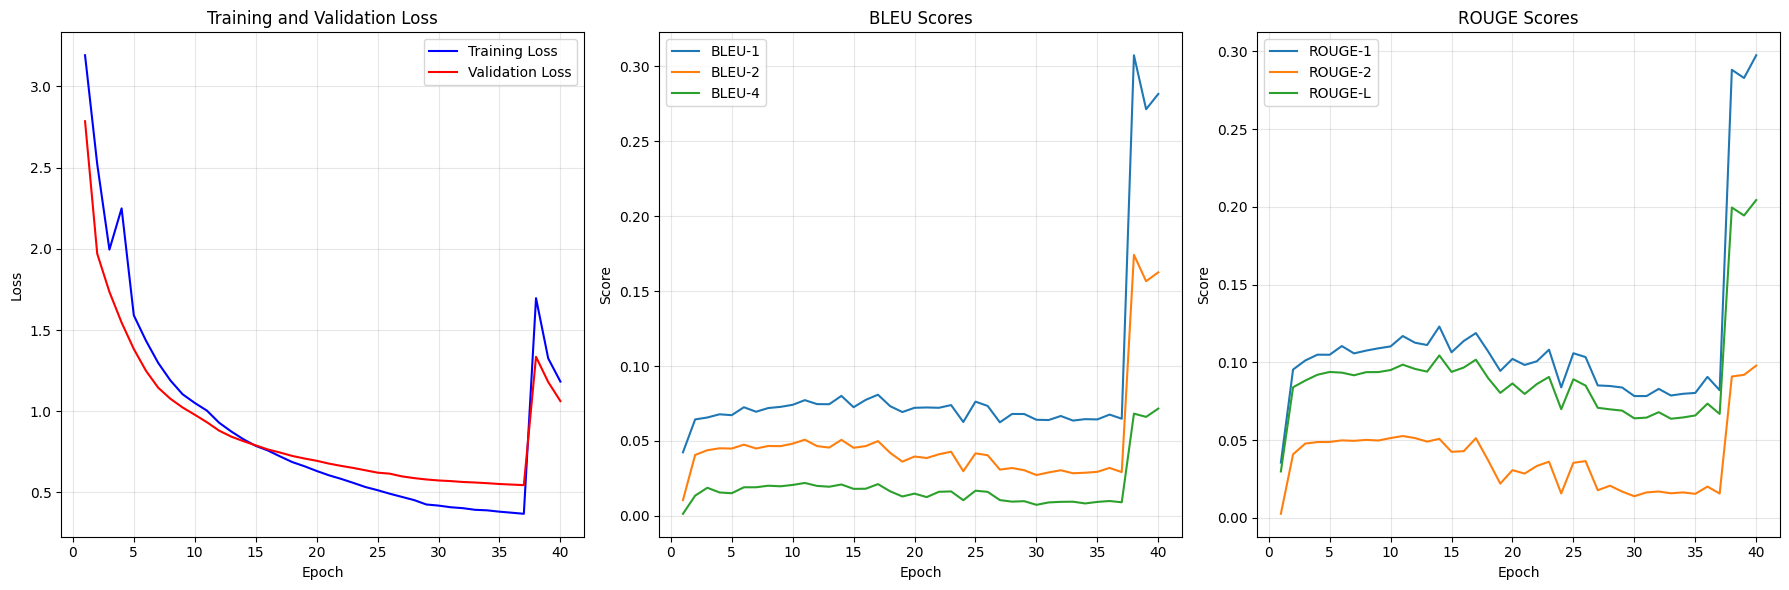

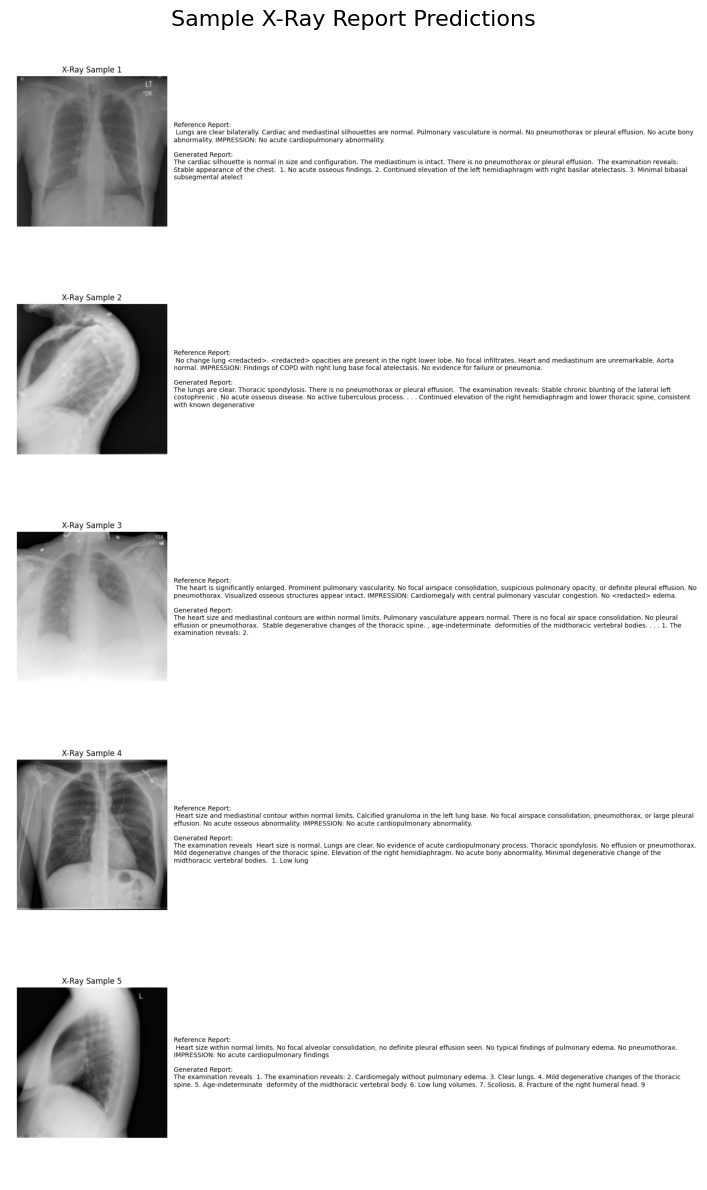

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from PIL import Image
import glob

def visualize_training_summary(history_path=None, plot_dir=None, sample_images=True):
    # Set default paths if none provided
    if history_path is None:
        history_path = os.path.join("./IUXRAY_OUTPUT_PIPELINE/checkpoints", "training_history.json")
    if plot_dir is None:
        plot_dir = "./IUXRAY_OUTPUT_PIPELINE/plots"
    
    # Load training history
    if os.path.exists(history_path):
        with open(history_path, 'r') as f:
            history = json.load(f)
        
        train_losses = history['train_losses']
        val_losses = history['val_losses']
        metrics_history = history['metrics_history']
        
        # Create a dataframe for metrics (without F1 scores)
        epochs = list(range(1, len(train_losses) + 1))
        data = {
            'Epoch': epochs,
            'Train Loss': train_losses,
            'Val Loss': val_losses
        }
        
        # Add BLEU and ROUGE metrics
        if metrics_history and len(metrics_history) > 0:
            metric_keys = ['bleu-1', 'bleu-2', 'bleu-3', 'bleu-4', 'rouge-1', 'rouge-2', 'rouge-l']
            for key in metric_keys:
                if key in metrics_history[0]:
                    data[key.upper()] = [m.get(key, 0) for m in metrics_history]
        
        # Create DataFrame and display as table
        df = pd.DataFrame(data).round(4)
        print("Training Metrics Summary:")
        display(df)
        
        # Create plots in a 1x3 layout (removing F1 scores)
        fig, axs = plt.subplots(1, 3, figsize=(18, 6))
        
        # Plot loss curves
        axs[0].plot(epochs, train_losses, 'b-', label='Training Loss')
        axs[0].plot(epochs, val_losses, 'r-', label='Validation Loss')
        axs[0].set_title('Training and Validation Loss')
        axs[0].set_xlabel('Epoch')
        axs[0].set_ylabel('Loss')
        axs[0].legend()
        axs[0].grid(True, alpha=0.3)
        
        # Plot BLEU scores
        metrics = ['bleu-1', 'bleu-2', 'bleu-4']
        has_bleu = False
        for metric in metrics:
            if metrics_history and metric in metrics_history[0]:
                values = [m.get(metric, 0) for m in metrics_history]
                axs[1].plot(epochs, values, label=f"BLEU-{metric[-1]}")
                has_bleu = True
        
        if not has_bleu:
            axs[1].plot(epochs, [0] * len(epochs), 'k--', alpha=0.3, label="No BLEU data")
            
        axs[1].set_title('BLEU Scores')
        axs[1].set_xlabel('Epoch')
        axs[1].set_ylabel('Score')
        axs[1].legend()
        axs[1].grid(True, alpha=0.3)
        
        # Plot ROUGE scores
        metrics = ['rouge-1', 'rouge-2', 'rouge-l']
        has_rouge = False
        for metric in metrics:
            if metrics_history and metric in metrics_history[0]:
                values = [m.get(metric, 0) for m in metrics_history]
                axs[2].plot(epochs, values, label=metric.upper())
                has_rouge = True
                
        if not has_rouge:
            axs[2].plot(epochs, [0] * len(epochs), 'k--', alpha=0.3, label="No ROUGE data")
            
        axs[2].set_title('ROUGE Scores')
        axs[2].set_xlabel('Epoch')
        axs[2].set_ylabel('Score')
        axs[2].legend()
        axs[2].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(os.path.join(plot_dir, 'training_summary.png'))
        plt.show()
        
        # Display sample prediction images if available
        if sample_images:
            # Check for prediction images in different naming patterns
            pred_image_patterns = [
                os.path.join(plot_dir, 'final_predictions_*.png'),
                os.path.join(plot_dir, 'example_predictions.png'),
                os.path.join(plot_dir, '*predictions*.png') 
            ]
            
            found_image = False
            for pattern in pred_image_patterns:
                pred_images = glob.glob(pattern)
                if pred_images:
                    latest_image = max(pred_images, key=os.path.getmtime)
                    
                    plt.figure(figsize=(15, 12))
                    img = plt.imread(latest_image)
                    plt.imshow(img)
                    plt.axis('off')
                    plt.title("Sample X-Ray Report Predictions", fontsize=16)
                    plt.tight_layout()
                    plt.show()
                    found_image = True
                    break
                    
            if not found_image:
                print("No prediction images found in the plots directory.")
        
        return df
    else:
        print(f"Error: Could not find training history at {history_path}")
        return None

# Execute the function
metrics_df = visualize_training_summary()

## Note on Epoch 37 Metrics Spike
The metrics spike at epoch 37 resulted from my accidental modification of the validation script. I changed how the model was evaluated midway through training, forgetting that the old checkpoint would be automatically removed as the new metrics appeared "better." This change in validation methodology created inconsistent metrics that shouldn't be directly compared to earlier epochs. I've since reverted to the original validation approach to ensure consistent evaluation across all epochs.


## visualize model predictions

Loading model from: ./IUXRAY_OUTPUT_PIPELINE/checkpoints/best_rouge_model.pth


/home/ubuntu/dl/dl-env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/dl/dl-env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model loaded successfully

Sample 1:
Word overlap: 14/32 words (43.8%)
Medical terms in reference: ['normal', 'effusion', 'pneumothorax']
Medical terms in generated: ['normal', 'effusion', 'pneumothorax', 'atelectasis', 'consolidation']
Model correctly identified some medical findings

Sample 2:
Word overlap: 8/32 words (25.0%)
Medical terms in reference: ['normal', 'effusion', 'pneumothorax', 'consolidation']
Medical terms in generated: ['normal', 'cardiomegaly', 'effusion', 'pneumothorax', 'atelectasis']
Model correctly identified some medical findings

Sample 3:
Word overlap: 13/15 words (86.7%)
Medical terms in reference: ['normal']
Medical terms in generated: ['normal', 'cardiomegaly', 'effusion', 'pneumothorax', 'atelectasis']
Model correctly identified some medical findings

Sample 4:
Word overlap: 9/33 words (27.3%)
Medical terms in reference: ['normal', 'effusion', 'pneumothorax']
Medical terms in generated: ['normal', 'effusion', 'pneumothorax', 'deformity']
Model correctly i

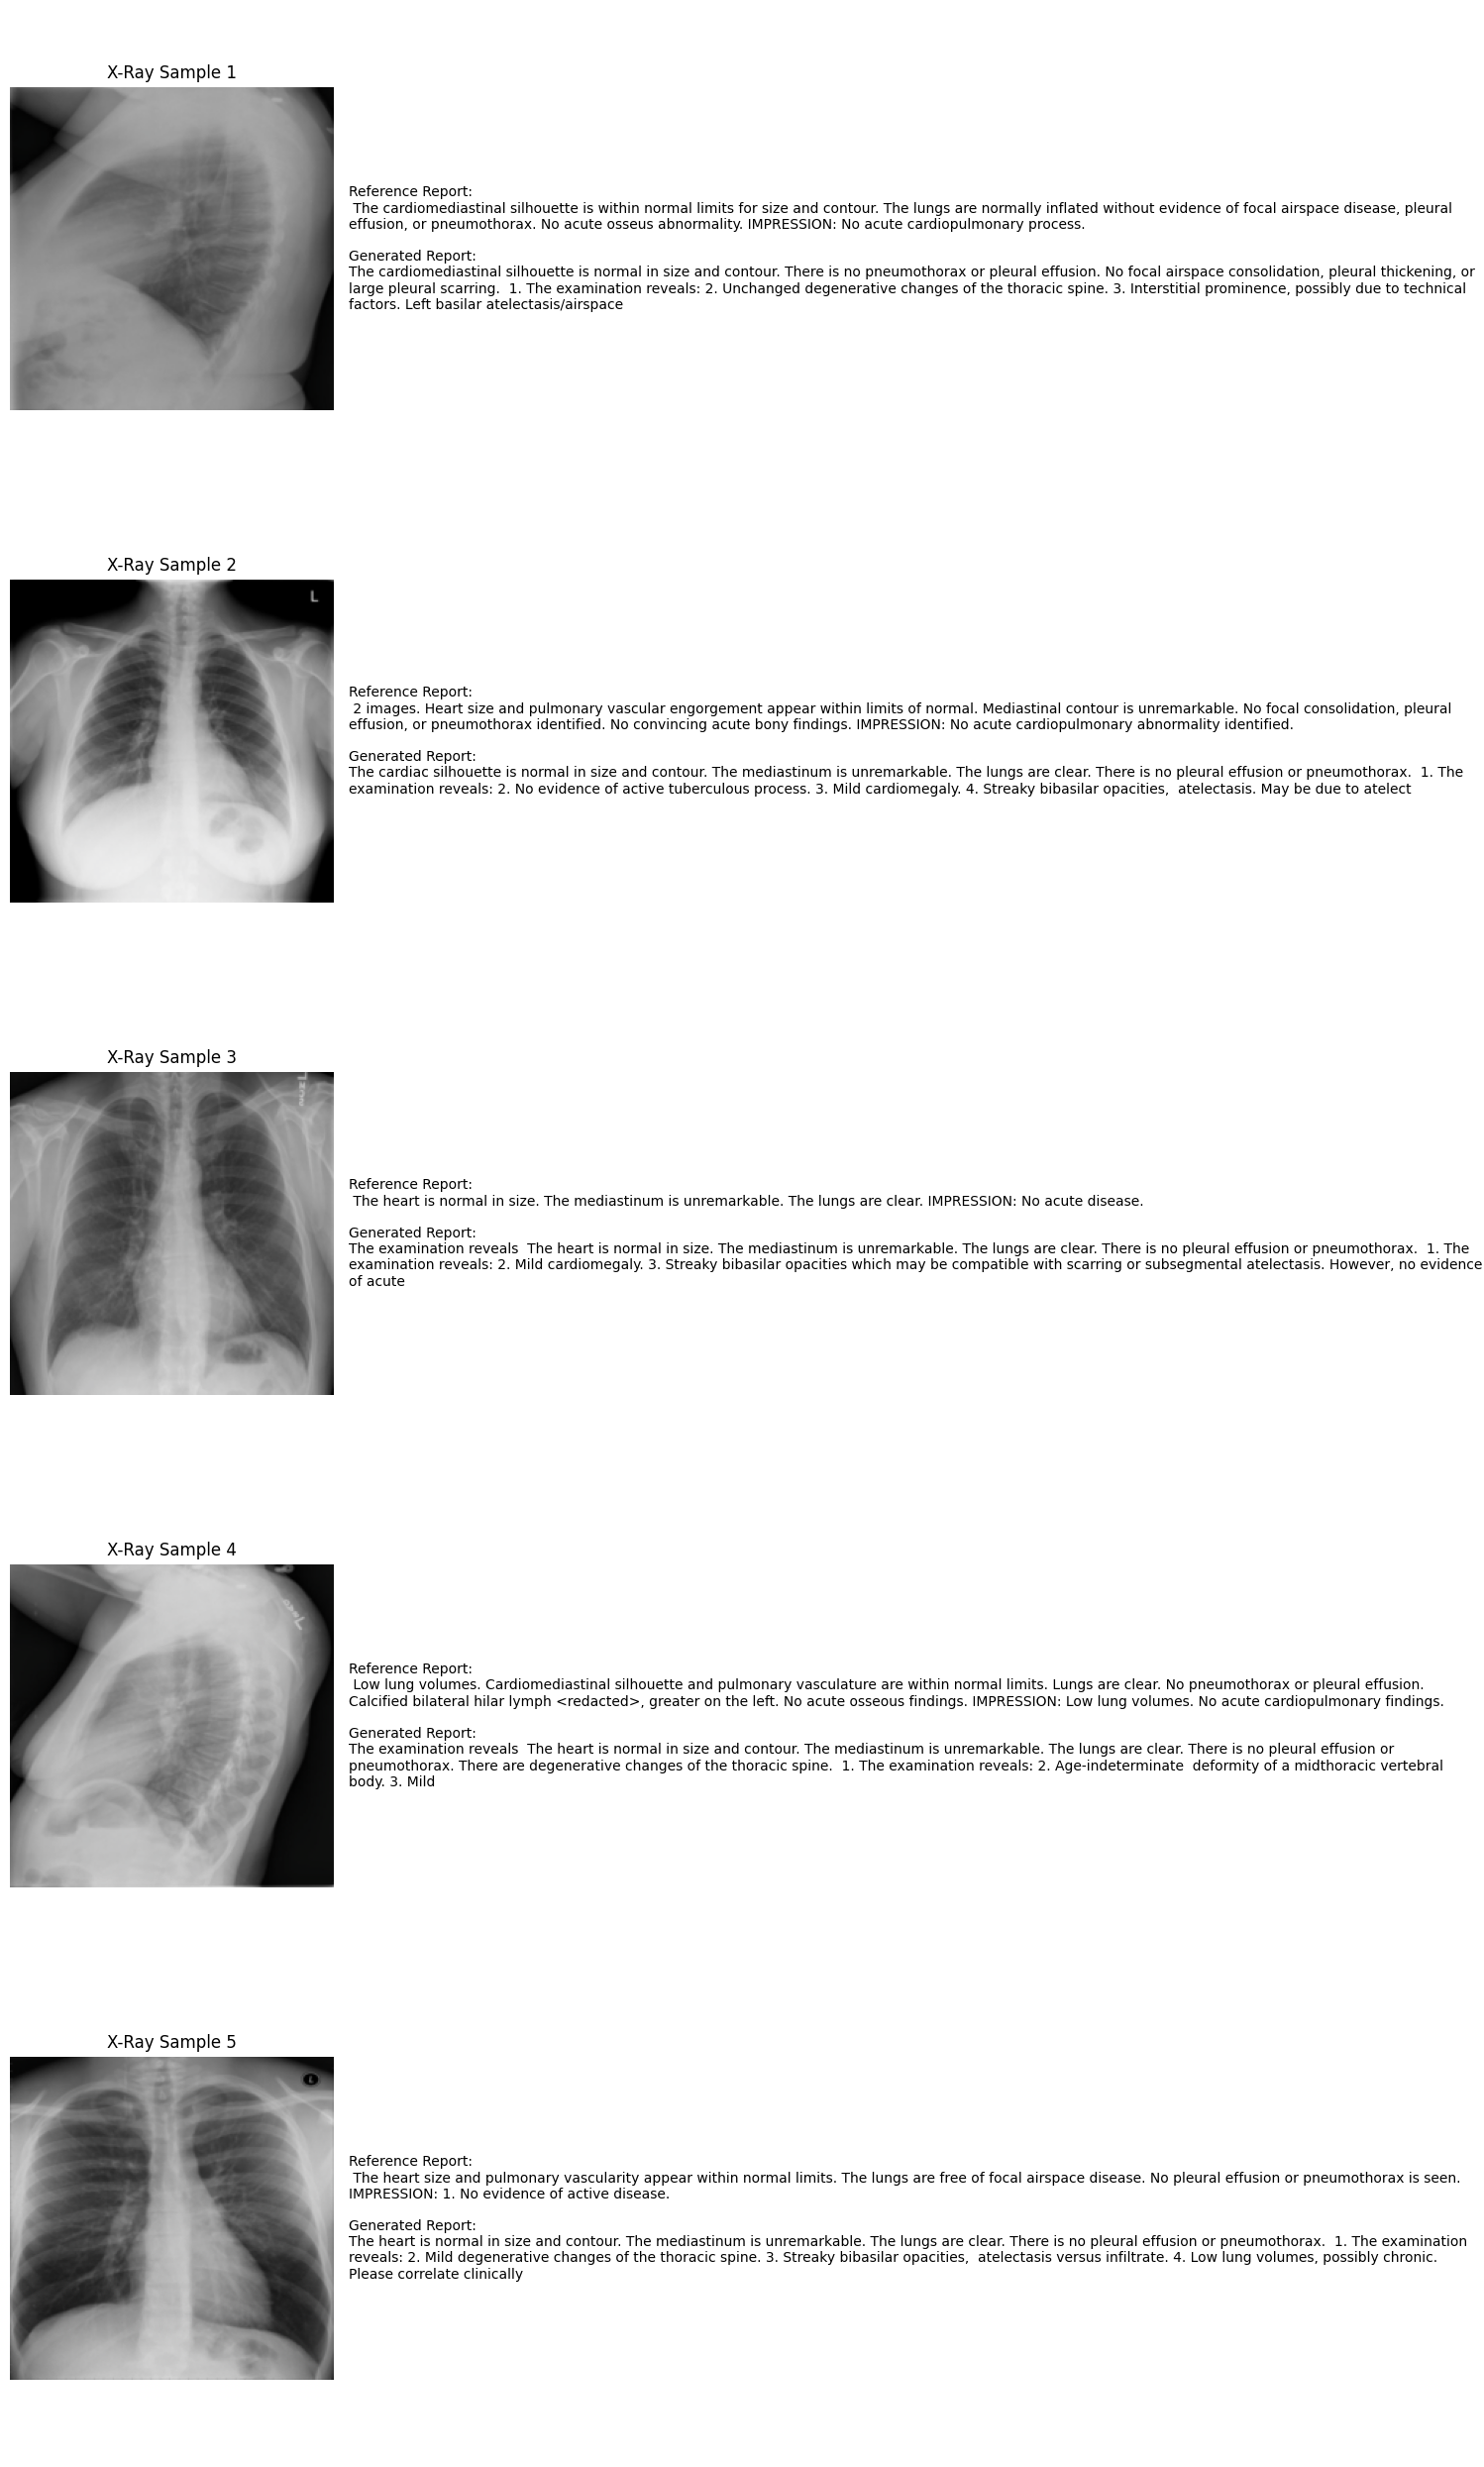

True

In [60]:
def visualize_model_predictions(num_samples=3, use_best_model=True, verbose=True):
    # Define paths
    CHECKPOINT_DIR = "./IUXRAY_OUTPUT_PIPELINE/checkpoints"
    
    if use_best_model:
        # Try both best models and use the one that exists
        best_paths = [
            os.path.join(CHECKPOINT_DIR, 'best_rouge_model.pth'),
            os.path.join(CHECKPOINT_DIR, 'best_bleu_model.pth')
        ]
        
        model_path = None
        for path in best_paths:
            if os.path.exists(path):
                model_path = path
                break
                
        if model_path is None:
            model_path = os.path.join(CHECKPOINT_DIR, 'latest_checkpoint.pth')
    else:
        # Use latest checkpoint
        model_path = os.path.join(CHECKPOINT_DIR, 'latest_checkpoint.pth')
    
    if verbose:
        print(f"Loading model from: {model_path}")
    
    # Load model
    try:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        checkpoint = torch.load(model_path, map_location=device)
        
        # Create model
        embed_size = 768  # Default GPT2 embedding size
        model = ResNetGPT2(tokenizer_global, pretrained=True, freeze_encoder=True).to(device)
        
        # Load model weights
        if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
            model.load_state_dict(checkpoint['model_state_dict'], strict=False)
        else:
            model.load_state_dict(checkpoint, strict=False)
            
        if verbose:
            print("Model loaded successfully")
        
        # Set model to evaluation mode
        model.eval()
        
        # Get a batch from test loader
        test_samples = []
        for batch in test_loader:
            test_samples = batch
            break
        
        # Select random samples
        indices = random.sample(range(len(test_samples['image'])), min(num_samples, len(test_samples['image'])))
        
        # Create figure for visualization
        fig, axes = plt.subplots(num_samples, 2, figsize=(15, 5 * num_samples), gridspec_kw={'width_ratios': [1, 3]})
        
        # Fix axes handling for different numbers of samples
        if num_samples == 1:
            # For single sample, make axes 2D by wrapping it in a list
            axes = np.array([axes])
        
        # Generate and display results
        with torch.no_grad():
            for i, idx in enumerate(indices):
                # Get image and move to device
                image = test_samples['image'][idx:idx+1].to(device)
                
                generated_text = model.generate(
                    images=image,  # Use image instead of images
                    tokenizer=tokenizer_global,
                    max_length=100,
                    num_beams=2
                )[0] 
                
                # Get reference text
                ref_text = test_samples['original_text'][idx]
                if '[FINDINGS]' in ref_text:
                    ref_text = ref_text.split('[FINDINGS]')[1]
                    if '[IMPRESSION]' in ref_text:
                        ref_text = ref_text.replace('[IMPRESSION]', 'IMPRESSION:')
                
                # Display image
                img = image.squeeze().cpu().permute(1, 2, 0).numpy()
                # Denormalize
                img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
                img = np.clip(img, 0, 1)
                
                # Fix the indexing into axes
                axes[i, 0].imshow(img, cmap='gray')
                axes[i, 0].set_title(f"X-Ray Sample {i+1}")
                axes[i, 0].axis('off')
                
                # Display text
                text = f"Reference Report:\n{ref_text}\n\n"
                text += f"Generated Report:\n{generated_text}"
                
                axes[i, 1].text(0, 0.5, text, fontsize=10, wrap=True, verticalalignment='center')
                axes[i, 1].axis('off')
                
                # Analyze medical term overlap
                ref_lower = ref_text.lower()
                gen_lower = generated_text.lower()
                
                medical_terms = ['normal', 'cardiomegaly', 'effusion', 'pneumothorax', 'opacity', 
                                'edema', 'atelectasis', 'pneumonia', 'consolidation', 'infiltrate',
                                'deformity', 'fracture', 'emphysema']
                
                ref_terms = [term for term in medical_terms if term in ref_lower]
                gen_terms = [term for term in medical_terms if term in gen_lower]
                
                # Calculate word overlap
                ref_words = set(ref_lower.split())
                gen_words = set(gen_lower.split())
                overlap = len(ref_words.intersection(gen_words))
                overlap_pct = overlap / max(1, len(ref_words)) * 100
                
                if verbose:
                    print(f"\nSample {i+1}:")
                    print(f"Word overlap: {overlap}/{len(ref_words)} words ({overlap_pct:.1f}%)")
                    print(f"Medical terms in reference: {ref_terms}")
                    print(f"Medical terms in generated: {gen_terms}")
                    
                    # Check for common findings
                    if any(term in gen_lower for term in ref_terms):
                        print("Model correctly identified some medical findings")
                    else:
                        print("Model missed medical findings in reference")
        
        plt.tight_layout()
        plt.savefig(os.path.join(PLOT_DIR, f'final_predictions_{num_samples}_samples.png'))
        plt.show()
        
        return True
        
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()
        return False

visualize_model_predictions(num_samples=5)